# PA005: High Value Customer Identification (Insiders)

## 0.0. Planejamento da Solução (IOT)


### Input - Entrada

1. Problema de Negócio
    * Selecionar os clientes mais valioses para integrar um programa de Fidelização
2. Conjunto de Dados
    * Vendas de um e-commerce online, dutante o período de um ano.

### Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: 
| client_id | is_insider |
|-----------|------------|
|    10323   |   yes/1    |
|    32413   |   no/1    |

2. Relatório com as perguntas de negócio
    * Quem são as pessoas elegíveis para participar do programa de Insiders?
    * Quantos clientes farão parte do grupo?
    * Quais as principais características desses clientes?
    * Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    * Qual a expectativa de faturamento desse grupo para os próximos meses?
    * Quais as condições para uma pessoa ser elegível ao Insiders?
    * Quais as condições para uma pessoa ser removida do Insiders?
    * Qual a garantia que o programa Insiders é melhor que o restante da base?
    * Quais ações o time de marketing pode realizar para aumentar o faturamento?

1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
        - Alto Ticket médio.
        - Alto LTV.
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta previsão de LTV.
        - Alta propensão de compra.
        
    - Custo:
        - Baixa taxa de devolução.
        
    - Experiência de compra:
        - Média alta das avaliações.

2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders

3. Quais as principais características desses clientes?
    - Escrever características do cliente:
        - Idade
        - Localização
    - Escrever características do consumo:
        - Atributos da clusterização

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano
    - Faturamento do grupo Insiders

5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders
    - Análise de Cohort
    
6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade (1 mês, 3 meses )
    - A pessoa precisa ser similar ou parecida com uma pessoa do grupo.

7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a peirodicidade (1 mês, 3 meses )
    - A pessoa precisa ser desimilar ou não-parecida com uma pessoa do grupo.

8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses.

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">0.0. Imports</p></div>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import inflection
import umap.umap_        as umap
import re

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from plotly     import express as px
from IPython.display import HTML

from sklearn          import cluster as c
from sklearn          import metrics as mt
from sklearn          import ensemble as en
from sklearn          import preprocessing as pp
from sklearn          import decomposition as dd
from sklearn          import mixture as mx
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from scipy.cluster import hierarchy as hc


from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings( 'ignore' )

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

C:\Users\Luan\anaconda3\envs\pa005cluster\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Luan\anaconda3\envs\pa005cluster\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\Luan\anaconda3\envs\pa005cluster\Lib\site-packages\umap\distances.py:

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

## 0.2. Load Dataset

In [3]:
# load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1 )


In [4]:
df_raw.head()

InvoiceNo StockCode                          Description  Quantity InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   29-Nov-16       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6   29-Nov-16       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   29-Nov-16       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   29-Nov-16       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   29-Nov-16       3.39     17850.0  United Kingdom

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.0. Data Description</p></div>

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate','UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old ))

#rename
df1.columns = cols_new

In [ ]:
df1.sample()

## 1.2. Data dimensions

In [8]:
print( 'Número de Linhas: {}\nNúmero de Colunas: {}'.format(df1.shape[0], df1.shape[1]) )

Número de Linhas: 541909
Número de Colunas: 8


## 1.3. Data types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NA

In [18]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [10]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [11]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.head()

invoice_no stock_code                          description  quantity invoice_date  unit_price         country  customer_id
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6    29-Nov-16        2.55  United Kingdom      17850.0
1     536365      71053                  WHITE METAL LANTERN         6    29-Nov-16        3.39  United Kingdom      17850.0
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8    29-Nov-16        2.75  United Kingdom      17850.0
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6    29-Nov-16        3.39  United Kingdom      17850.0
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6    29-Nov-16        3.39  United Kingdom      17850.0

In [12]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

##  1.6 Change types

In [12]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( 'int64' )

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [15]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median ) ).T

# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply(np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply(np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply(np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew()) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes       min      max      range          mean    median          std        skew       kurtosis
0     quantity -80995.00  80995.0  161990.00      9.552250      3.00   218.080957   -0.264076  119769.160031
1   unit_price -11062.06  38970.0   50032.06      4.611114      2.08    96.759764  186.506972   59005.719097
2  customer_id  12346.00  22709.0   10363.00  16688.840453  16249.00  2911.408666    0.487449      -0.804287

#### 1.7.1.1. Numerical Attributes - Investigating

1. Quantity negativa ( pode ser devolução )

2. Preço unitário igual a zero ( pode ser promoção? )

### 1.7.2. Categorical Attributes

#### Invoice number

In [16]:
# problema: Temos invoce com letras e numeros
# identificação:
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print( 'Total number of invoices: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[df_letter_invoices['quantity'] < 0] ) ) )

Total number of invoices: 9291
Total number of negative quantity: 9288


#### Stock code

In [16]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Ação:
# 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [23]:
# Ação: Delete description

#### Country

In [16]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">2.0. Variable Filters</p></div>  

In [17]:
df2 = df1.copy()

In [18]:
# ===== Numerical Attributes =====
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# ==== Categorical attributes ====
# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446]) ]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">3.0. Feature Engineering</p></div> 

In [19]:
df3 = df2.copy()

## 3.1. Feature Creation

In [20]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates( ignore_index=True )

### 3.1.1. Gross Revenue

In [21]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby( 'customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [22]:
# Recency - Last day purchase
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchased

In [23]:
# Número de produtos 
df_freq = ( df2_purchase[['customer_id', 'invoice_no']].drop_duplicates()
                                                          .groupby( 'customer_id' )
                                                          .count()
                                                          .reset_index()
                                                          .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4. Quantity of items purchased

In [24]:
# Número de produtos 
df_freq = df2_purchase[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'qtde_items'})
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

### 3.1.5 Quantity of products purchased

In [25]:
# Número de produtos 
df_freq = ( df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                              .reset_index()
                                                              .rename( columns={'stock_code': 'qtde_products'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

### 3.1.5. Average Ticket Value

In [26]:
# Avg Ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'} )
df_avg_ticket['avg_ticket'] = np.round( df_avg_ticket['avg_ticket'], 2 )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

### 3.1.6. Average Recency Days

In [27]:
# Average Recency Days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=[True, True] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customere
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

### 3.1.7. Frequency Purchase

In [28]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg( max_ = ('invoice_date', 'max'),
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_ = ('invoice_date', lambda x: (( x.max() - x.min() ).days) + 1),
                                                                   buy_ = ('invoice_no', 'count') ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1 )

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8. Number of Returns

In [29]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity': 'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0 

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9. Basket Size - Quantidade de itens por cesta

In [30]:
df_aux = ( df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                              .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                    n_products=( 'quantity', 'sum') )
                                                              .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.2.0. Unique Basket Size - Quantidade de produtos distintos por compra

In [31]:
df_aux = ( df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                              .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                    n_products=( 'stock_code', 'nunique') )
                                                              .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">4.0. EDA (Exploratory Data Analysis)</p></div>   

In [32]:
df4 = df_ref.dropna().copy()

## 4.1. Univariate Analysis

In [30]:
#profile = ProfileReport( df4 )
#profile.to_file( 'output_2.html' )

**Notes**
1. Clusters Coesos - Separados
2. Métricas
    - Min, Max, Range ( disperssão )
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de variação
    - Distribuição

## 4.2. Bivariate Analysis

In [33]:
cols = ['customer_id']
df42 = df4.drop( columns=cols )

<Figure size 2500x1200 with 0 Axes>

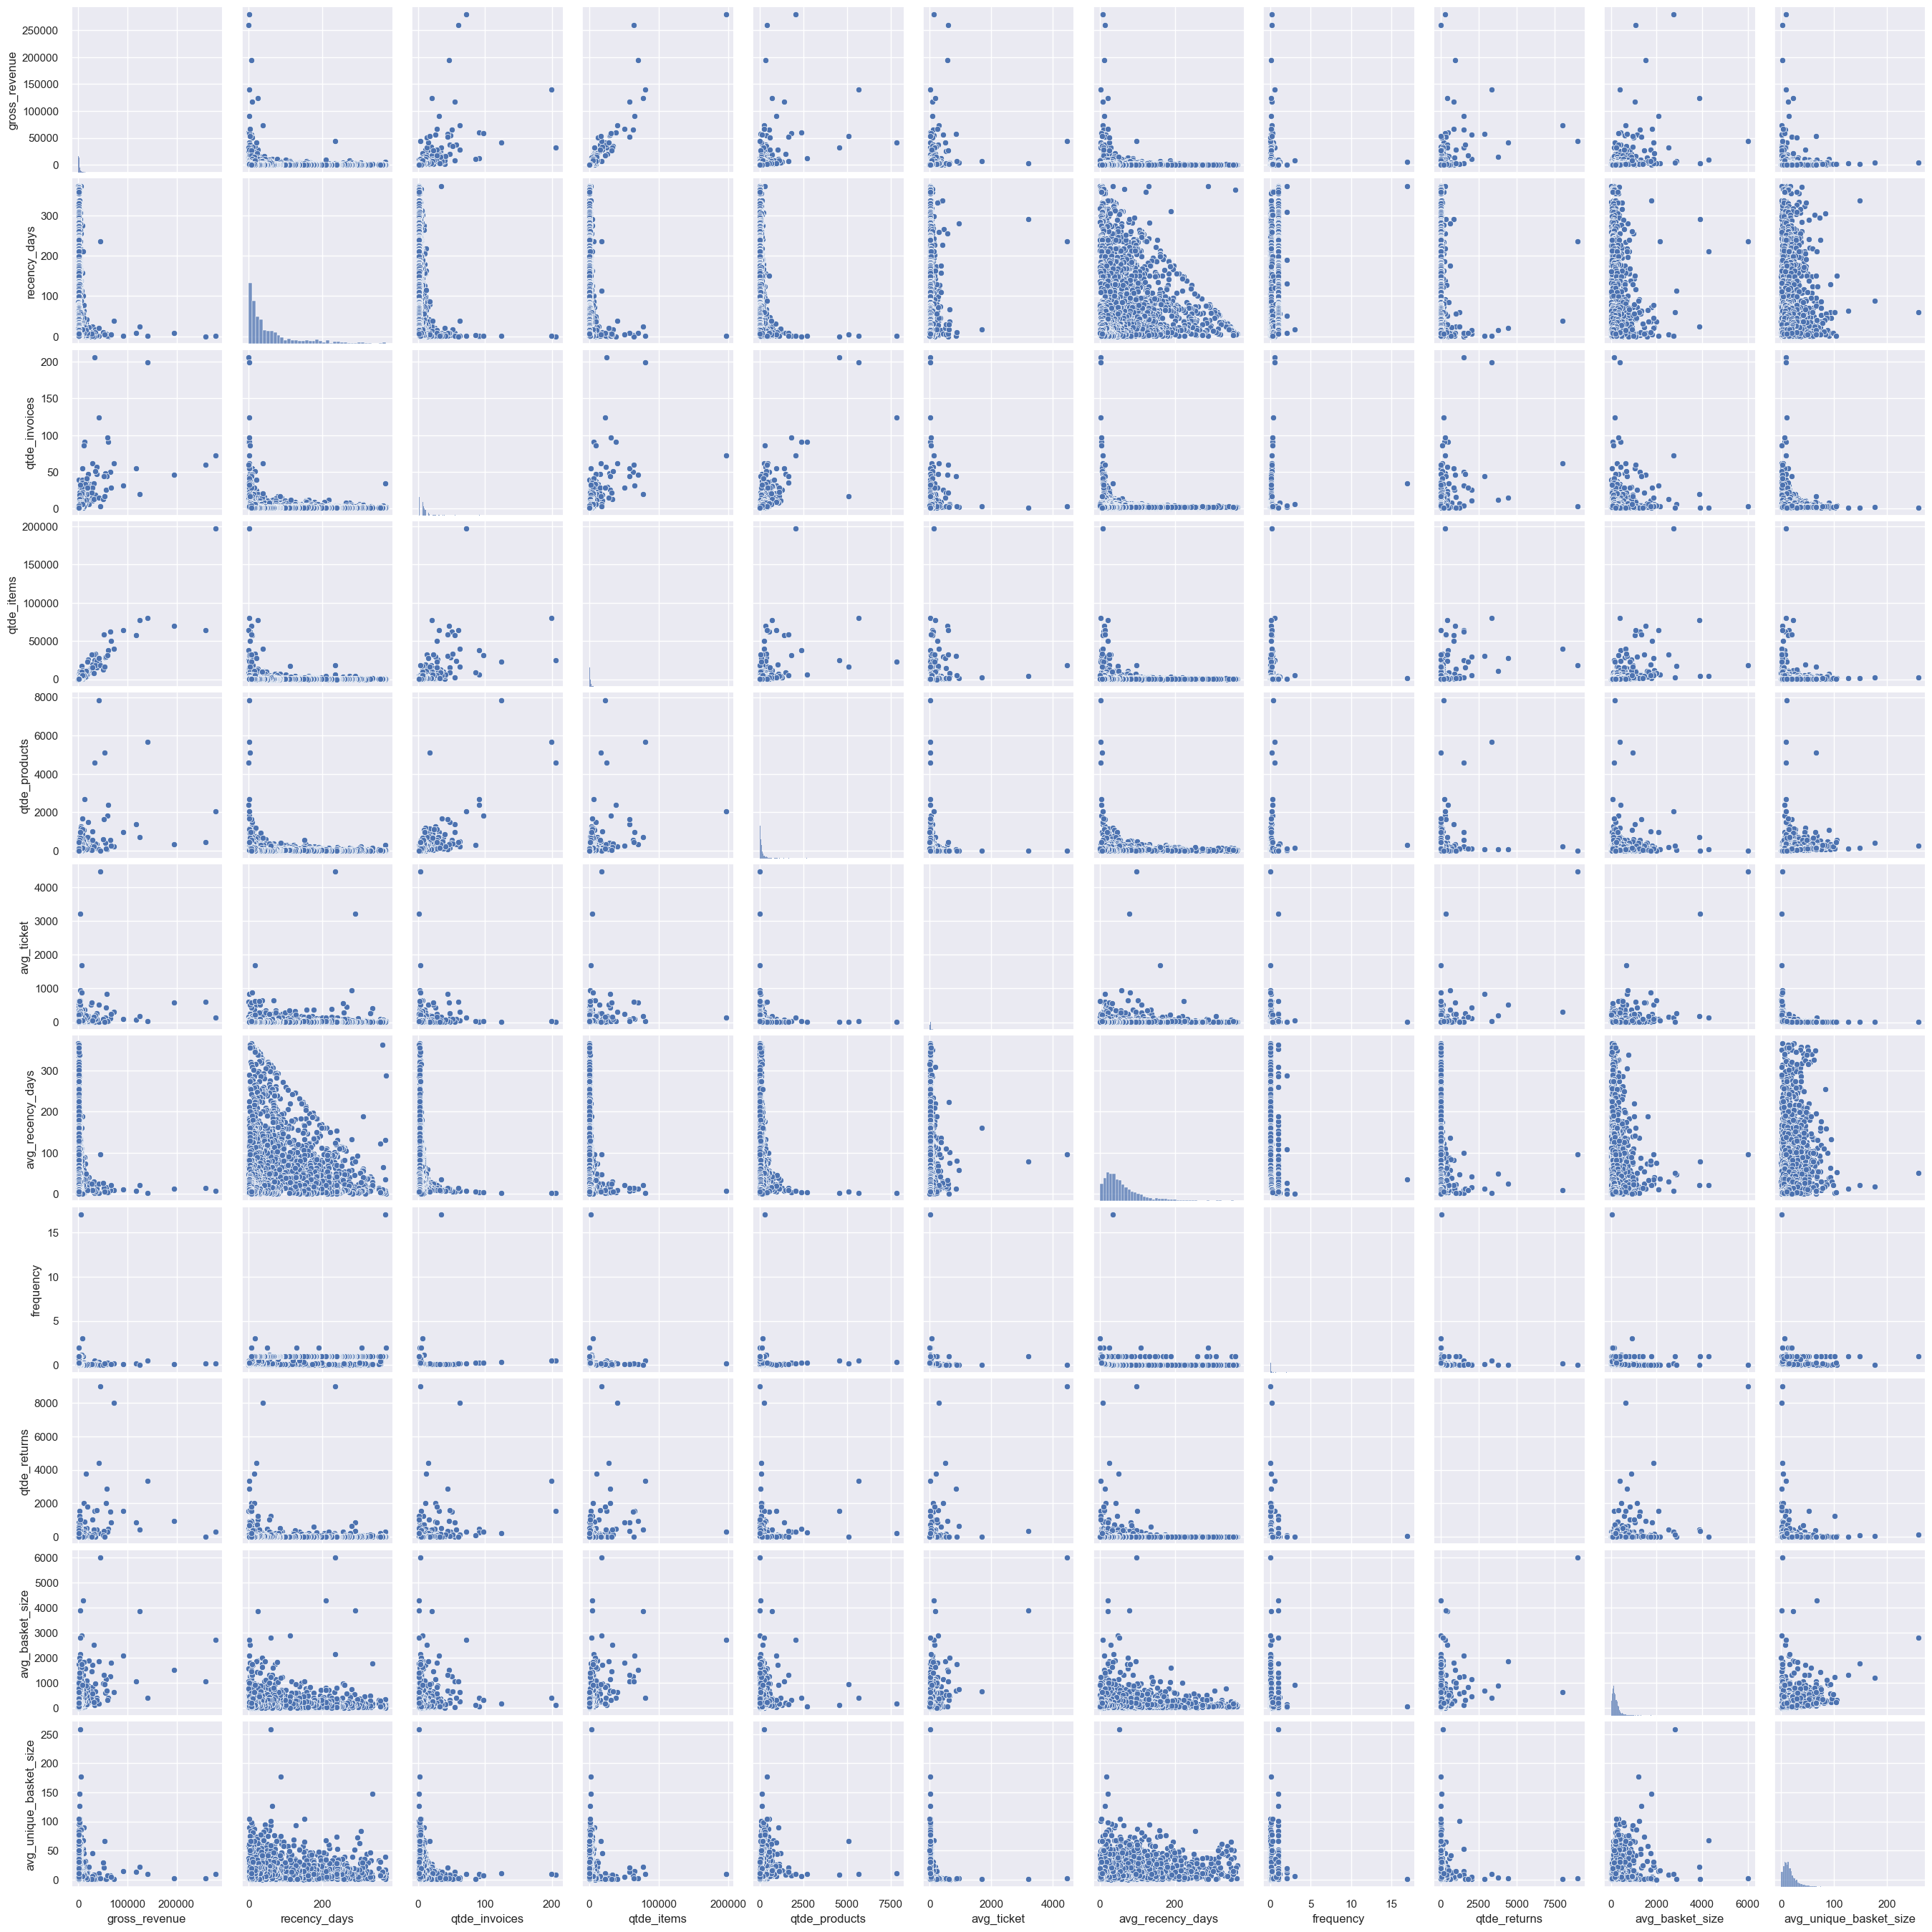

In [34]:
plt.figure( figsize=[25,12] )
sns.pairplot( df42)

## 4.3. Estudo do Espaço

In [34]:
# original dataset
#df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].copy()

In [35]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days'] = mm.fit_transform( df43[['recency_days']] )
#df43['qtde_invoices'] = mm.fit_transform( df43[['qtde_invoices']] )
#df43['qtde_items'] = mm.fit_transform( df43[['qtde_items']] )
df43['qtde_products'] = mm.fit_transform( df43[['qtde_products']] )
#df43['avg_ticket'] = mm.fit_transform( df43[['avg_ticket']] ) 
#df43['avg_recency_days'] = mm.fit_transform( df43[['avg_recency_days']] )
df43['frequency'] = mm.fit_transform( df43[['frequency']] )
df43['qtde_returns'] = mm.fit_transform( df43[['qtde_returns']] )
#df43['avg_basket_size'] = mm.fit_transform( df43[['avg_basket_size']] )
#df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )

X = df43.copy()

### 4.3.1. PCA

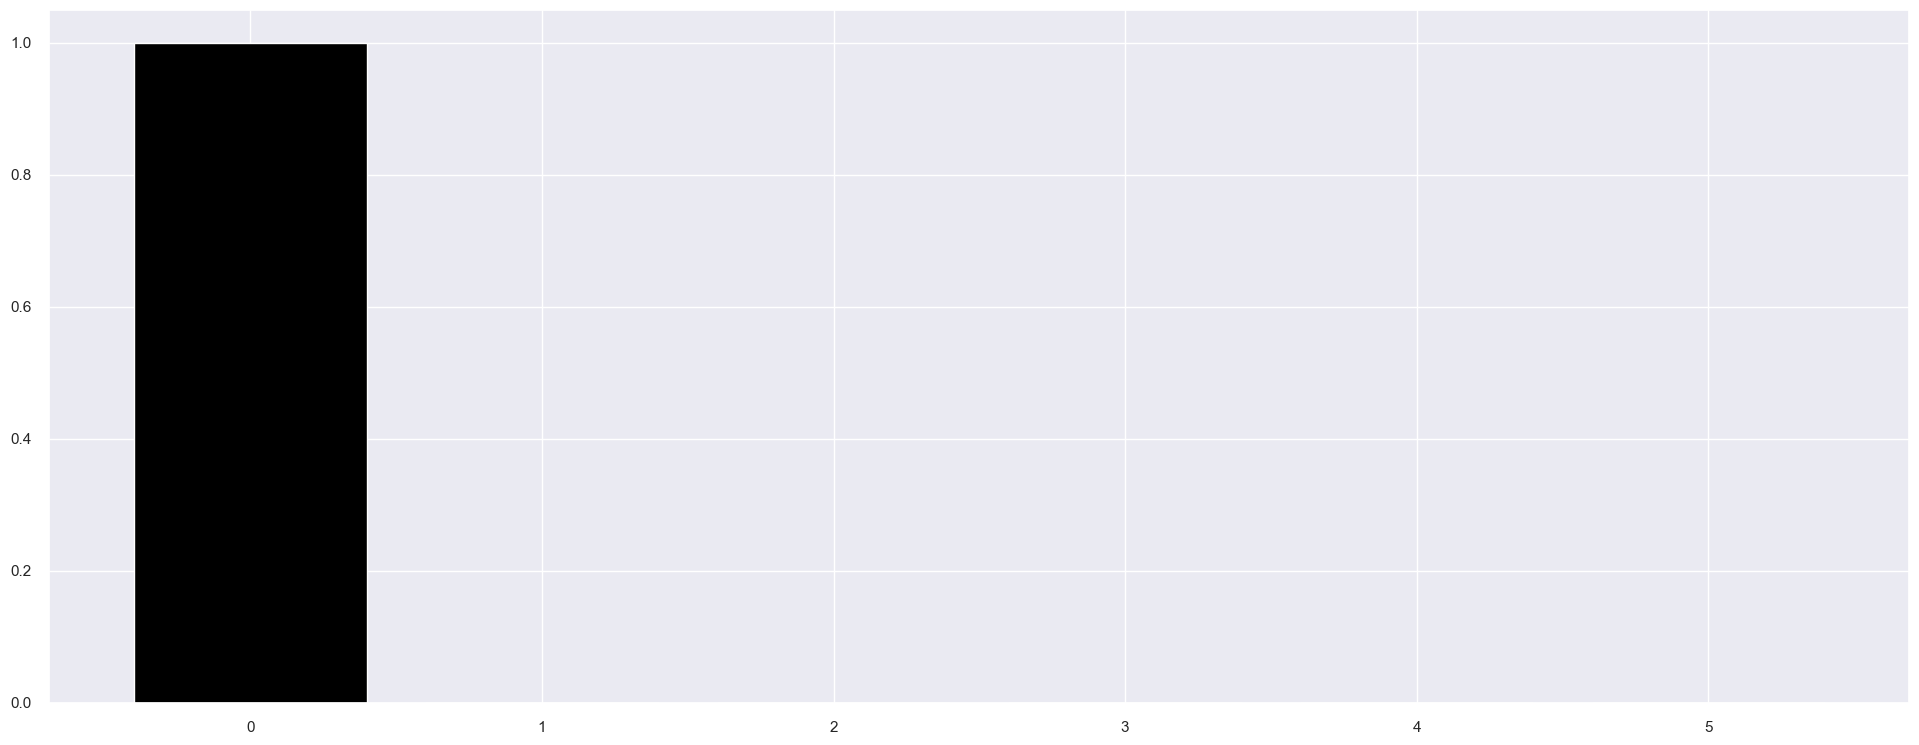

In [36]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explaned variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

<AxesSubplot: xlabel='0', ylabel='1'>

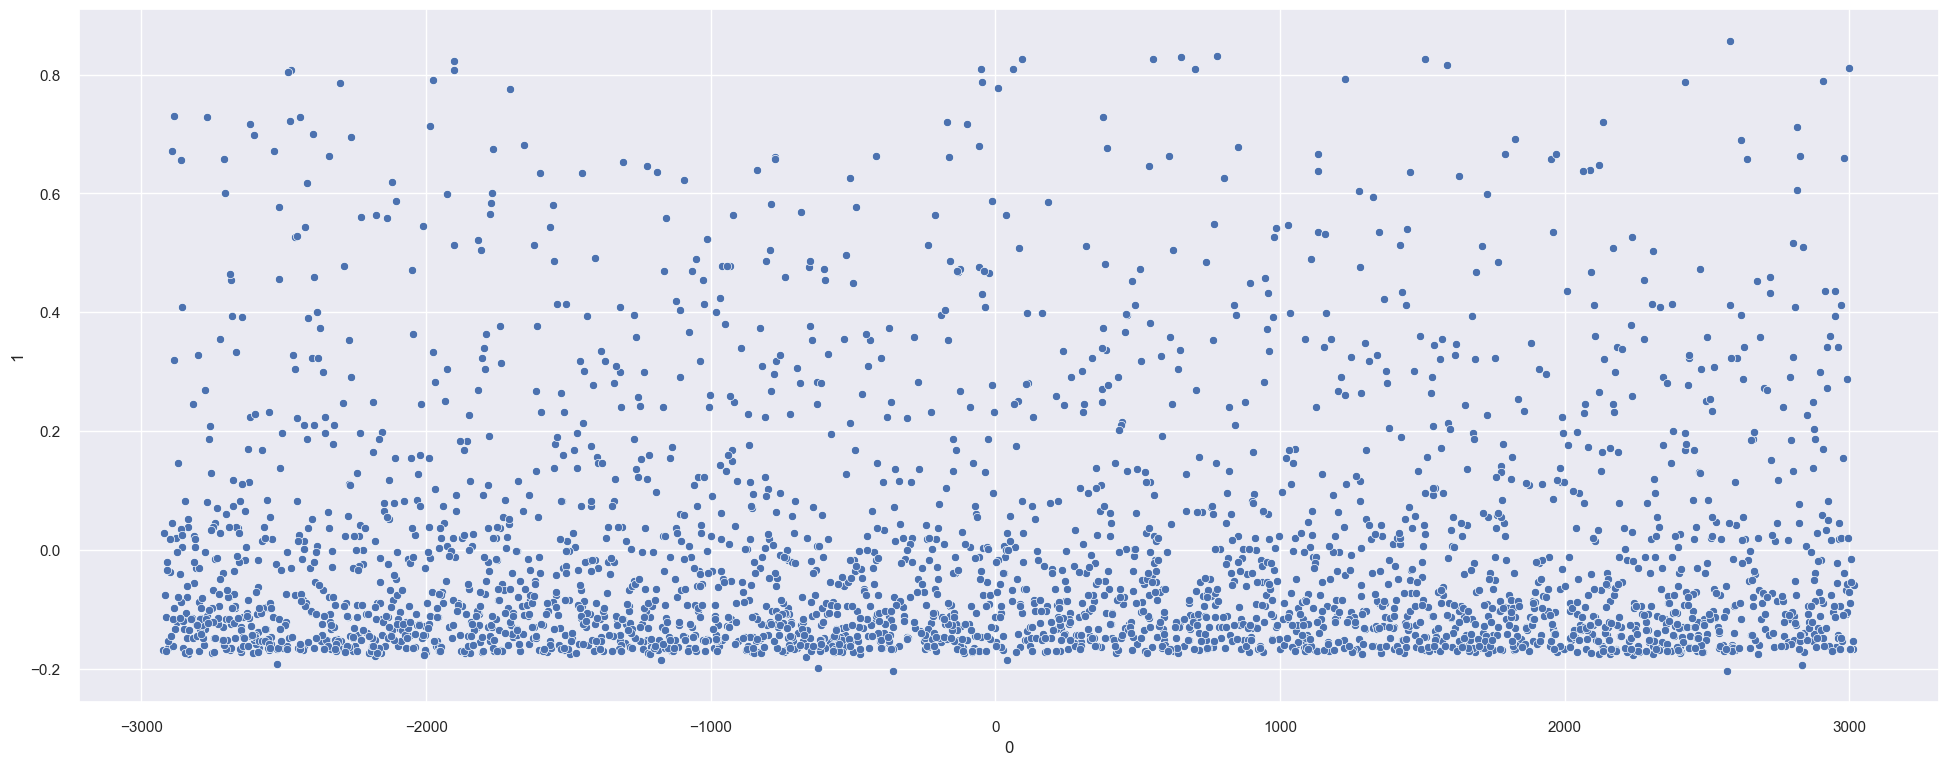

In [37]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 4.3.2. UMAP

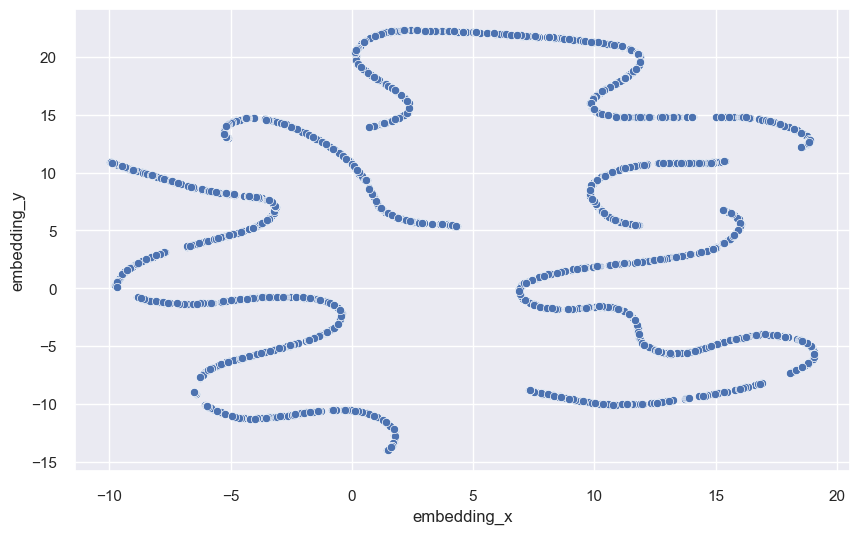

In [38]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_pca )
plt.show()

### 4.3.2. t-SNE

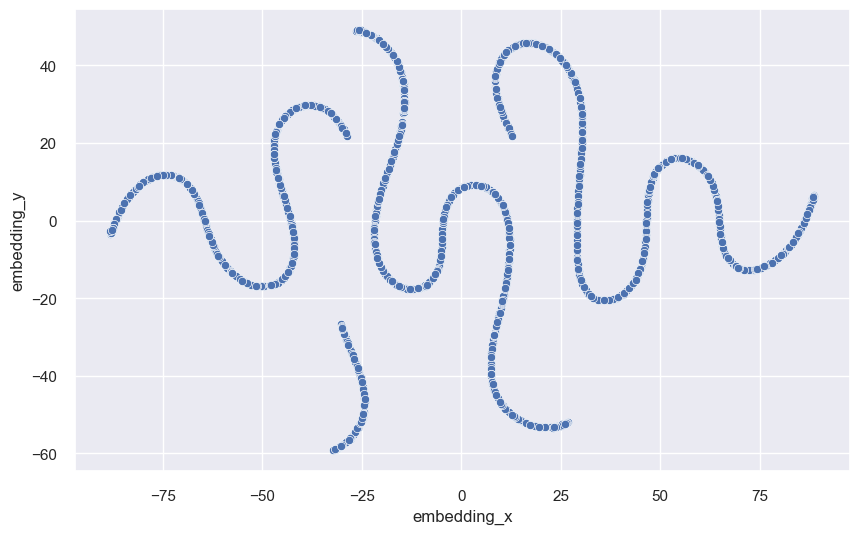

In [39]:
reducer = TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_pca )
plt.show()

### 4.3.3. Tree-Based Embedding

In [40]:
# training dataset
X = df43.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )


RandomForestRegressor(random_state=42)

In [42]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

In [43]:
df_leaf.head(6)

0     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99
0  3466  3439  3726  3677  3655  3752  3611  3688  3684  3490  3668  3543  3545  3578  3553  3490  3316  3420  3407  3244  3527  3653  3637  3582  3500  3425  3283  3394  3394  3762  3305  3603  3336  3458  3561  3391  3487  3654  3458  3617  3502  3624  3646  3676  3413  3437  3500  3741  3593  3378  3567  3545  3517  3392  3744  3697  3394  3656  3437  3696  3484  3482  3534  3759  3641  3490  3496  3563  3513  3520  3708  3734  3642  3704  3711  3513  3647  3562  3649  3410  3577  3546  3505  3670  3467  3629  3666  3687  3624  3411  3450  3392  3421  3679  3588  3704  3667  3406  3622  3653
1  3334  3394  3600  3055  3024  3386  3150  3515  3314  3244  3048  3445  3306  3396  3497  3407  3289  3277  3323  3173  3360  3524  2894  2898  3370  3219  3274  3304  3254  3155  3244  3424  3316  3311  3316  3371  3372  3140  3058  3057  3361  3170  3065  3126  3381  3411  3298  3262  3338  3253  3145  3423  3509  2992  3511  3103  3333  3650  3202  3231  3359  3301  2964  3147  3452  3210  3068  2860  3412  3255  3180  3106  3163  2701  3290  3124  3227  3429  3367  3389  3282  3268  3370  3534  3340  3069  3276  3153  3045  3385  2810  3271  3056  2967  3407  2983  2976  3308  3023  3509
2  3517  2982  3627  3580  3555  3666  3282  3551  3329  3330  3613  3473  3422  3517  3470  3471  3021  3360  3447  3236  3476  3518  3268  3246  3401  3381  3030  3350  3206  3659  3248  3414  3297  3495  3512  3467  3534  3580  3482  3536  3556  3224  3553  3562  3316  3423  3355  3239  3540  3380  3558  3500  3452  3467  3566  3645  3486  3534  3210  3311  3491  3440  3522  3638  3492  3442  3247  3560  3456  3001  3642  3646  3655  3621  3051  3509  3273  3505  3397  3075  3261  3221  3399  3558  3406  3560  3291  3713  3331  3434  3420  3341  3477  3531  3527  3590  3042  3381  3537  3584
3  1127   543  1214   307   854   346   537   933  1296  1146   814   361   569   465  1075   820   927   720   379  1104   564   393  1254   426   466   587  1233   646  1161   326   621   544  1212   985  1159  1041  1426   397   399  1281   591  1262  1031   540  1138  1022   588   469   722   971   407   386  1115   601  1504  1154   313   531   785   364   649   970   996  1268  1131   315   497   869   323  1107   671  1254   360  1471  1257   665   607  1209  1236   387  1164  1135  1042  1158   374   971   978   957   750  1130   538  1545   576   600  1057  1308   568   523   924   890
4   436   631   377   889   911   778  1022    36   562   485   143   511    50   714   528   460   544  1104   719   574   688    91   135   712   888   740    83   925   544  1690    59   652   596   336   473   493   361  1242   717   735   676   752   620    68   528   387   784   647   987   731   825   706   322  1022   536   496  1025    95   122  1035  1059   716   591   499   543   622   603   360   631   600   961   774   948    86   106   911   973   512   502   651    53   104   105   717   658   508   493   725  1055   506   894   611   877   700   763   468   689   882  1318   461
5  2790  3285  2763  2938  3043  2749  2362  2420  3293  2475  3097  2747  2902  2886  2931  2515  2931  2300  2840  2421  2930  2881  3240  3190  2922  2447  2400  2759  2413  3051  2436  2768  2497  2574  2455  2450  2793  2955  3036  2423  2936  3086  3118  2956  2450  2350  2408  2484  2519  2420  2969  2477  2843  2483  2666  2899  2524  2458  2352  2926  2574  2462  3038  3137  2858  

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

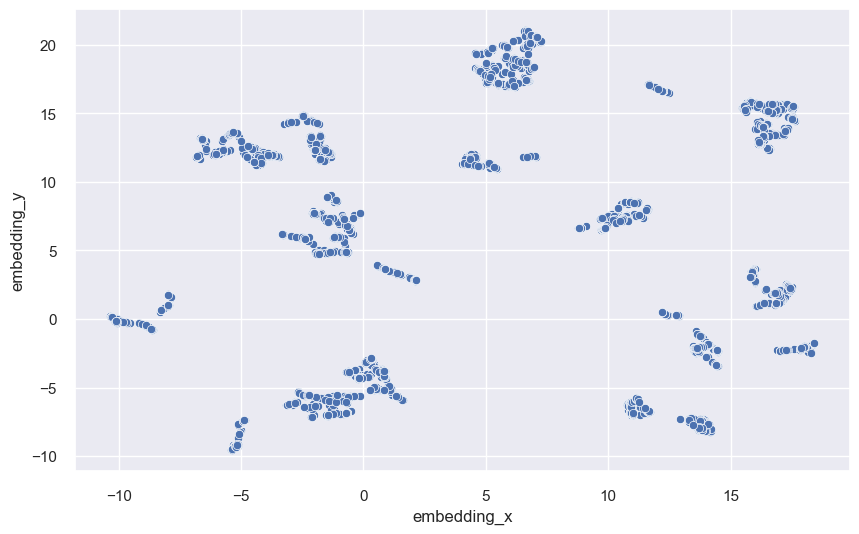

In [44]:
# reduzer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 data=df_tree )

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">5.0. Data Preparation</p></div>    

In [45]:
#df5 = df4.copy()
df5_aux = df_tree.copy()

In [46]:
#mm = pp.MinMaxScaler()
#ss = pp.StandardScaler()
#rs = pp.RobustScaler()
#
#df5['gross_revenue'] = mm.fit_transform( df5[['gross_revenue']] )
#df5['recency_days'] = mm.fit_transform( df5[['recency_days']] )
##df5['qtde_invoices'] = mm.fit_transform( df5[['qtde_invoices']] )
##df5['qtde_items'] = mm.fit_transform( df5[['qtde_items']] )
#df5['qtde_products'] = mm.fit_transform( df5[['qtde_products']] )
##df5['avg_recency_days'] = mm.fit_transform( df5[['avg_recency_days']] )
##df5['avg_ticket'] = mm.fit_transform( df5[['avg_ticket']] )
#df5['frequency'] = mm.fit_transform( df5[['frequency']] )
#df5['qtde_returns'] = mm.fit_transform( df5[['qtde_returns']] )
##df5['avg_basket_size'] = mm.fit_transform( df5[['avg_basket_size']] )
##df5['avg_unique_basket_size'] = mm.fit_transform( df5[['avg_unique_basket_size']] )

In [47]:
df5.head()

NameError: name 'df5' is not defined

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">6.0. Feature Selection</p></div>     

In [73]:
#cols_select = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [48]:
#df6 = df5[cols_select].copy()
df6 = df_tree.copy()

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">7.0. Hiperparameter Fine-Tunning</p></div>      

In [49]:
#X = df6.drop( columns=['customer_id'] )
X = df_tree.copy()

In [50]:
X.head()

embedding_x  embedding_y
0    -0.778533    -5.890829
1    -8.853444    -0.554059
2    -0.952055    -6.903424
3    10.397234     7.949393
4    16.530142     1.103087

In [51]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]
clusters = np.arange( 2, 26, 1)

## 7.1. K-Means

In [52]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # model training
    kmeans_model.fit( X )

    # model predict
    labels = kmeans_model.predict( X )

    # model performance
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

Text(0.5, 1.0, 'Silhouette Score x K')

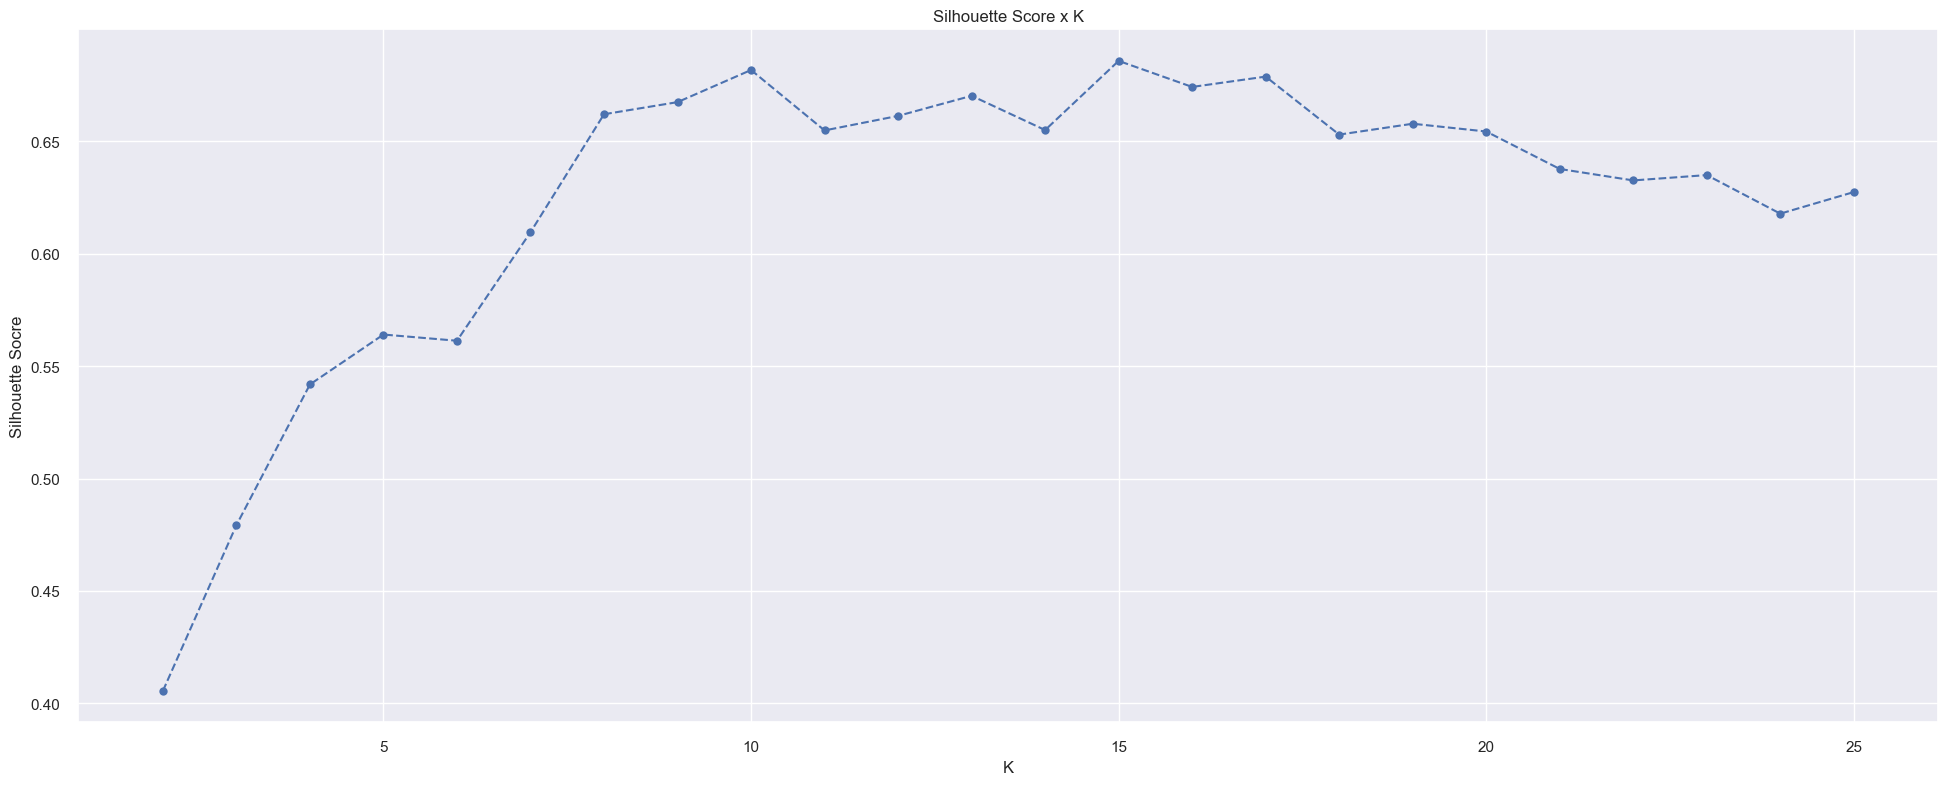

In [53]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Socre' )
plt.title( 'Silhouette Score x K' )

## 7.2. GMM

In [54]:
gmm_list =[]
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # model training
    gmm_model.fit( X )

    # model predict
    labels = gmm_model.predict( X )

    # model performance
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

Text(0.5, 1.0, 'Sil x K')

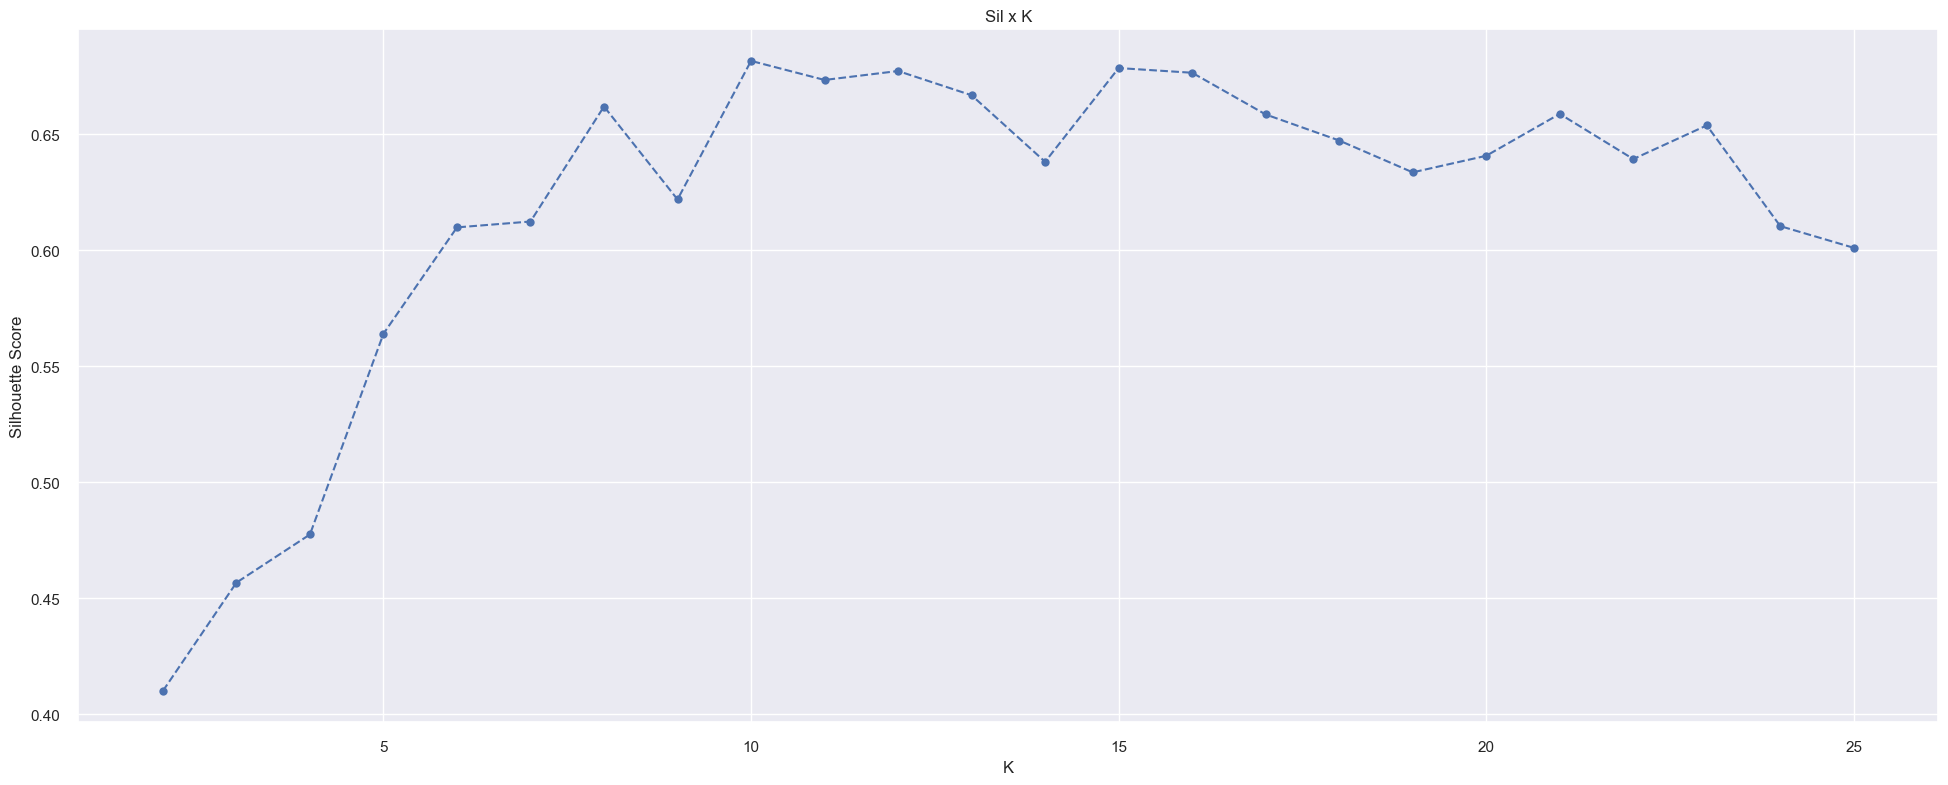

In [55]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' )
plt.ylabel( 'Silhouette Score' )
plt.title( 'Sil x K' )

## 7.3. Hierarchical Clustering

In [56]:
# model definition and trainig
hc_model = hc.linkage( X, 'ward' )

In [57]:
#hc.dendrogram(
#    hc_model,
#    leaf_rotation=90,
#    leaf_font_size=8
#)
#
#plt.plot()

In [58]:
#hc.dendrogram(
#    hc_model,
#    truncate_mode='lastp',
#    p=12,
#    leaf_rotation=90,
#    leaf_font_size=8,
#    show_contracted=True
#)
#
#plt.show()

### 7.3.1. HClustering Silhouette Score

In [59]:
hc_list = []
for k in clusters:
    # model definition e training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = mt.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

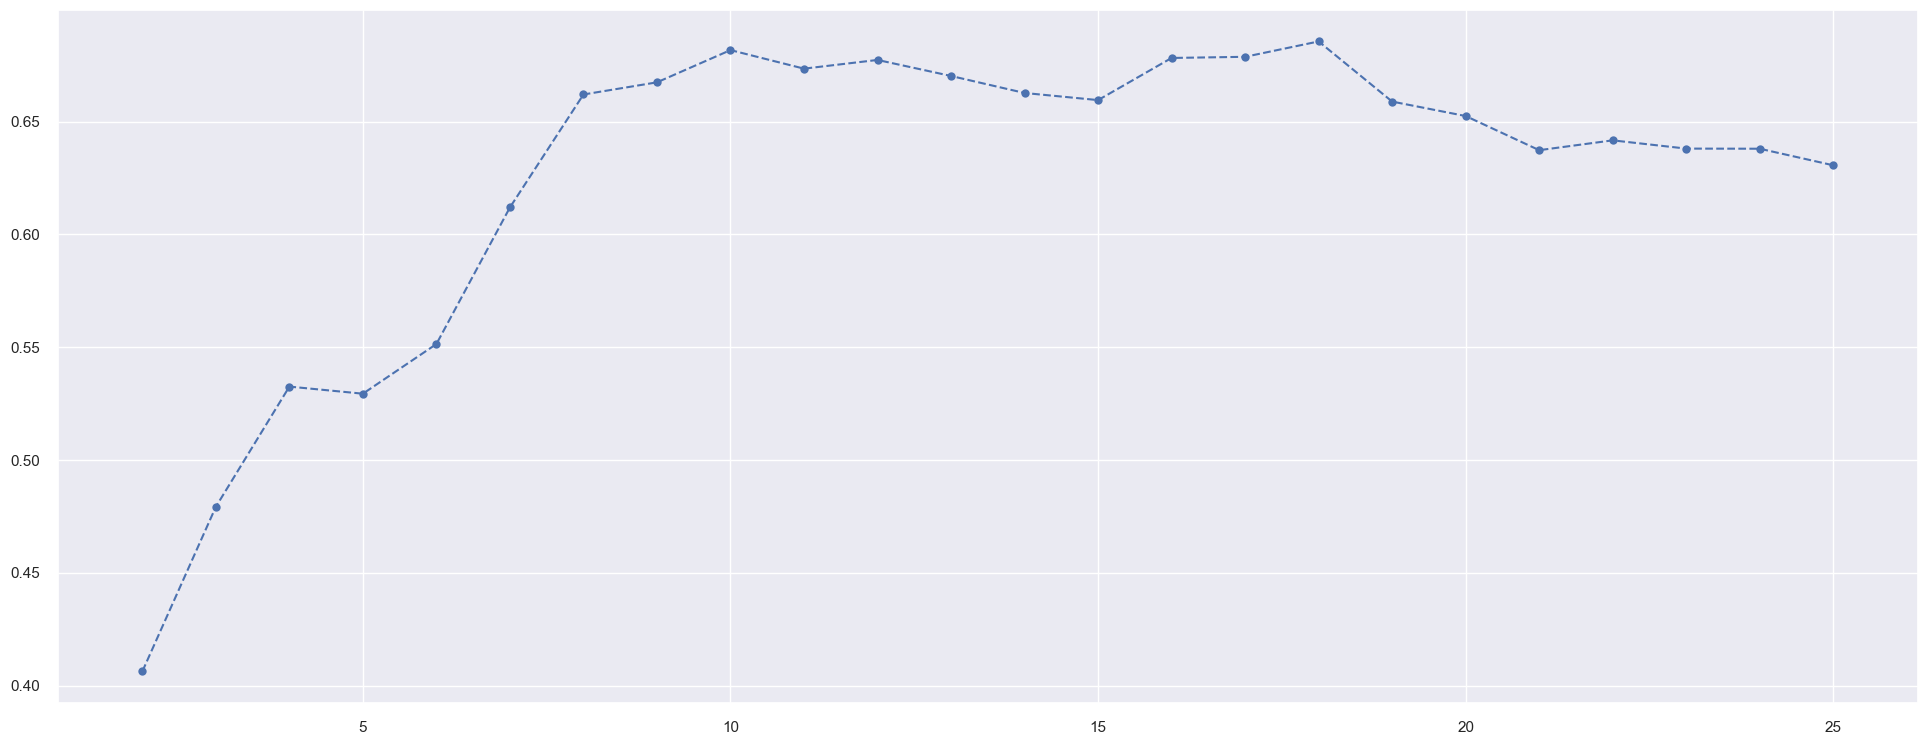

In [60]:
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b' )

## 7.4. DBSCAN

In [61]:
eps=2.00
min_samples=20

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# model training and predict
labels = dbscan_model.fit_predict( X )

sil = mt.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
#print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
#print( unique(labels) )

Silhouette Score: 0.6928880214691162


In [62]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

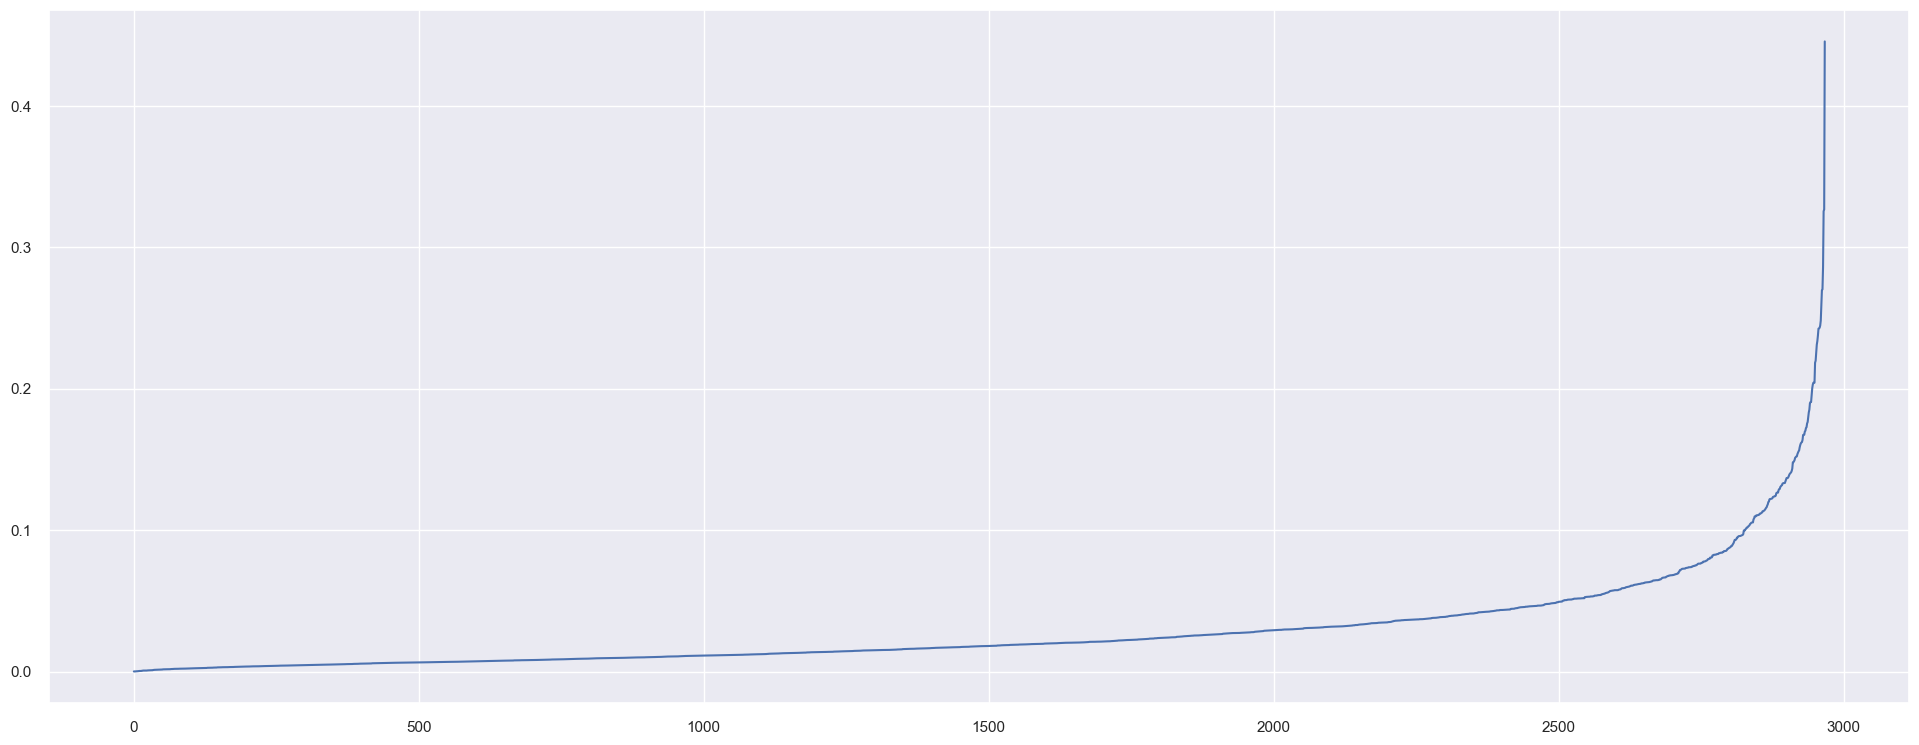

In [63]:
distances = np.sort( distances, axis=0 )
distances = distances[:, 1]
plt.plot( distances )

In [64]:
dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5. Results

In [65]:
df_results = pd.DataFrame( 
    {'kMeans': kmeans_list,
     'GMM': gmm_list,
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
     ).T
df_results.columns = clusters

In [66]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

For K = 2. Silhouette Score: 0.4062511622905731
For K = 3. Silhouette Score: 0.479255735874176
For K = 4. Silhouette Score: 0.5325373411178589
For K = 5. Silhouette Score: 0.5293877720832825
For K = 6. Silhouette Score: 0.5514118075370789
For K = 7. Silhouette Score: 0.6119778752326965


IndexError: index 3 is out of bounds for axis 0 with size 3

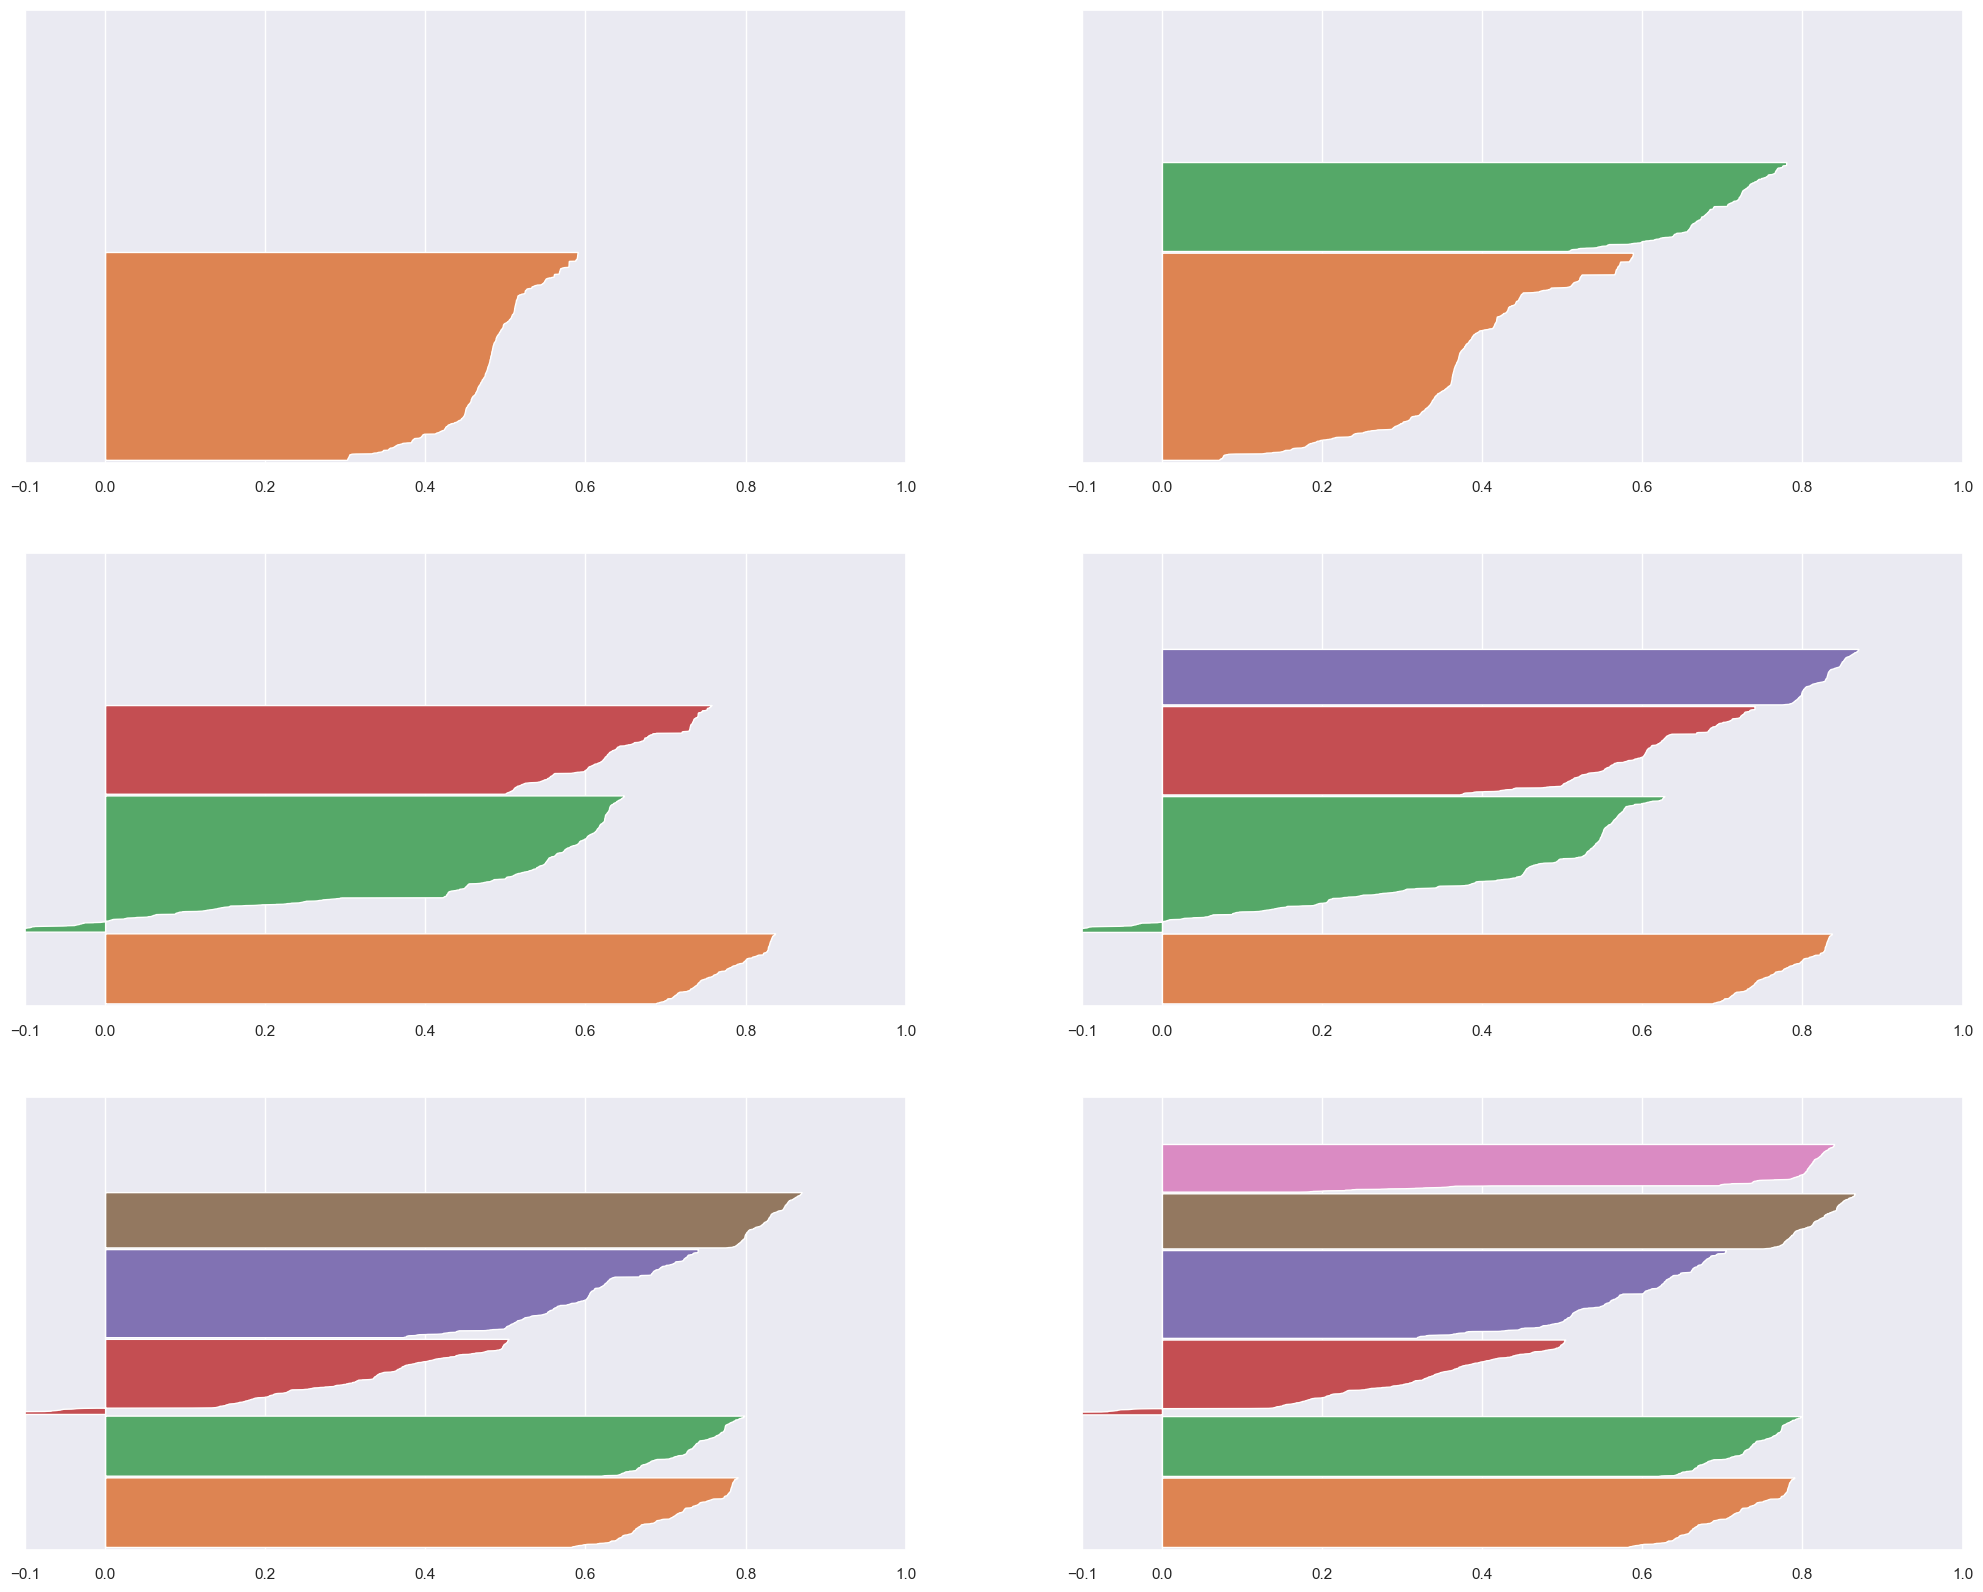

In [67]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1 ] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )

    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = mt.silhouette_score( X, labels, metric='euclidean' )
    print( 'For K = {}. Silhouette Score: {}'.format( k, ss ) )
    
    samples_silhouette_values = mt.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels==i ]
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [69]:
#kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
#kmeans.fit( X )
#kmeans.show()

In [68]:
#kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette',  timings=False )
#kmeans.fit( X )
#kmeans.show()

## 7.1. Sillhouette Analysis

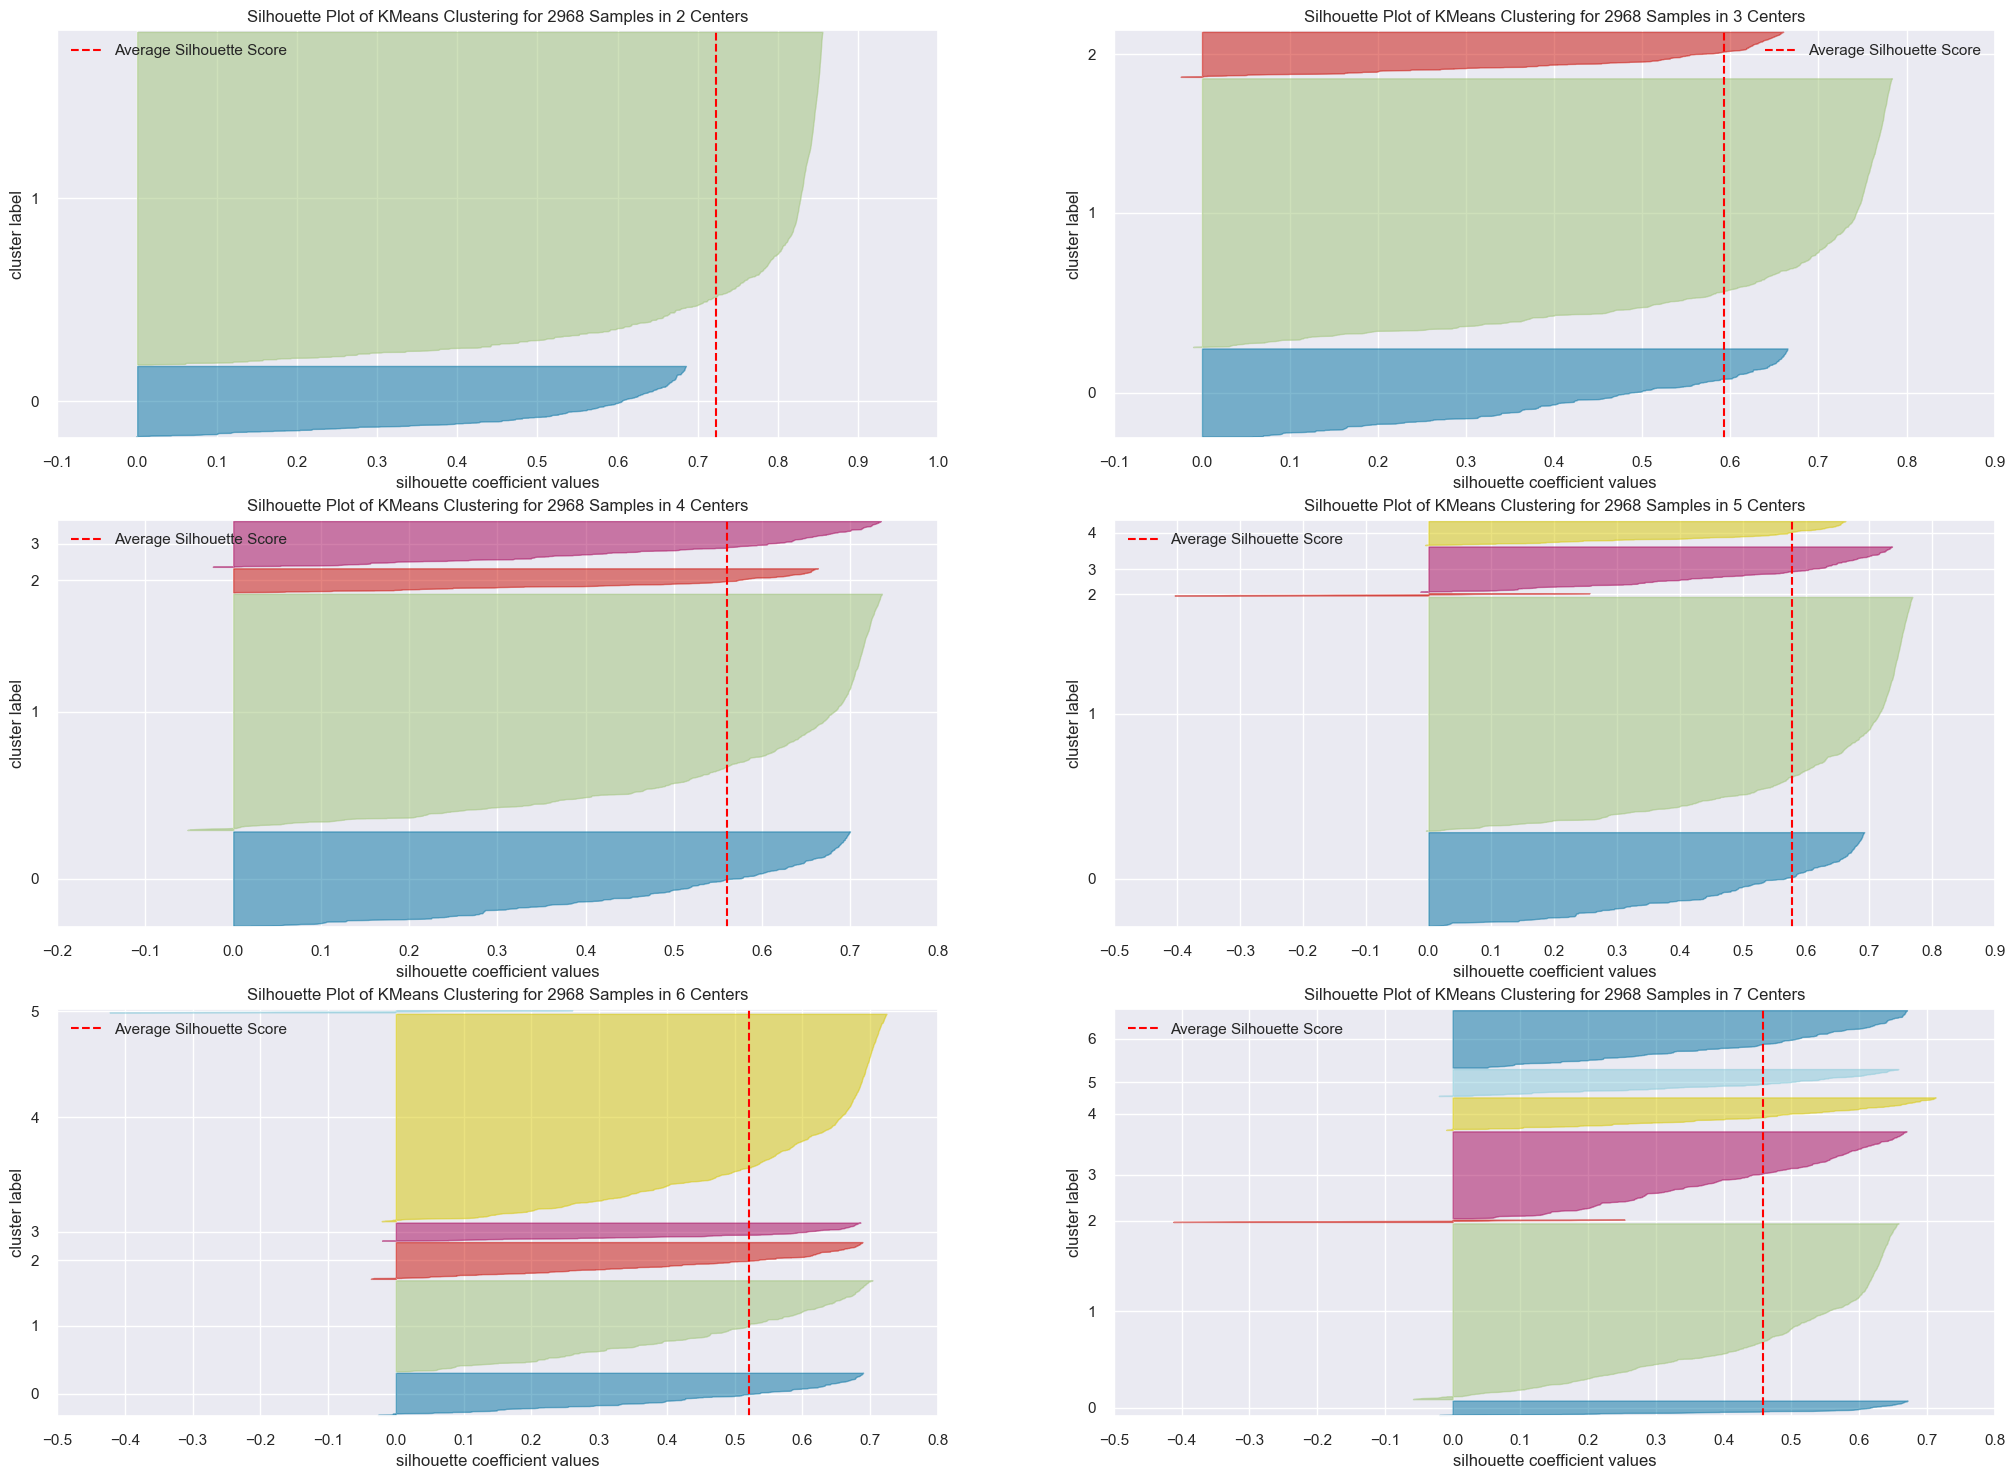

In [93]:
fig, ax = plt.subplots( 3, 2, figsize=(25, 18) )

for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42 )
    q, mod = divmod( k, 2 )
    
    visualizer = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q-1][mod] )
    visualizer.fit( X )
    visualizer.finalize()

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">8.0. Model Training</p></div>       

## 8.1. K-Means

In [98]:
# model definition
k = 8
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

# model training
kmeans.fit( X )

# clustering 
labels = kmeans.labels_

In [99]:
#k=8
## model definition
#gmm_model = mx.GaussianMixture( n_components=k )
#
## model training
#gmm_model.fit( X )
#
## model predict
#labels = gmm_model.predict( X )

## 8.2. Cluster Validation

In [100]:
## WSS ( Within-Cluster Sum of Square )
print( 'WSS value: {}'.format(kmeans.inertia_ ) )

## SS ( Silhouette Score )
print( 'SS value: {}'.format( mt.silhouette_score( X, labels, metric='euclidean' ) ) )

WSS value: 24745.484375
SS value: 0.6620461344718933


# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">9.0. Cluster Analysis</p></div>        

In [101]:
df9 = X.copy()
df9['cluster'] = labels

In [102]:
#df92 = df4.copy()
#df9['cluster'] = labels
#df9.head()

## 9.1. Visualization Inspection

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

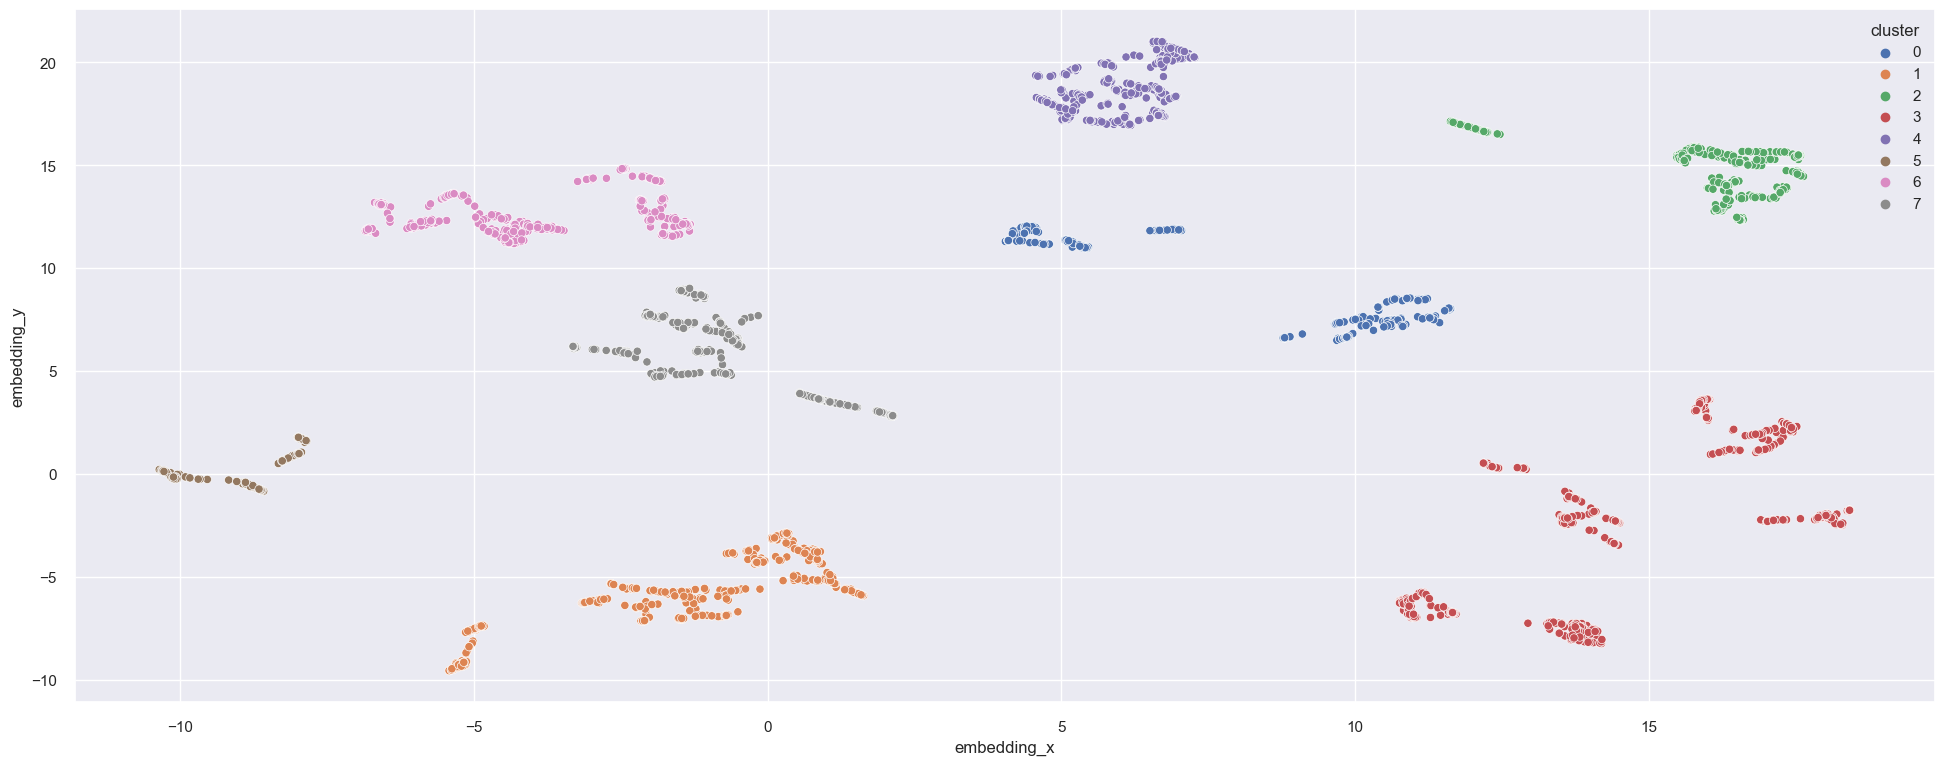

In [103]:
sns.scatterplot( x='embedding_x', y='embedding_y', data=df9, hue='cluster', palette='deep')

In [85]:
#visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
#visualizer.fit( X )
#visualizer.finalize()

In [ ]:
#fig = px.scatter_3d( df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
#fig.show()

## 9.2. 2d plot

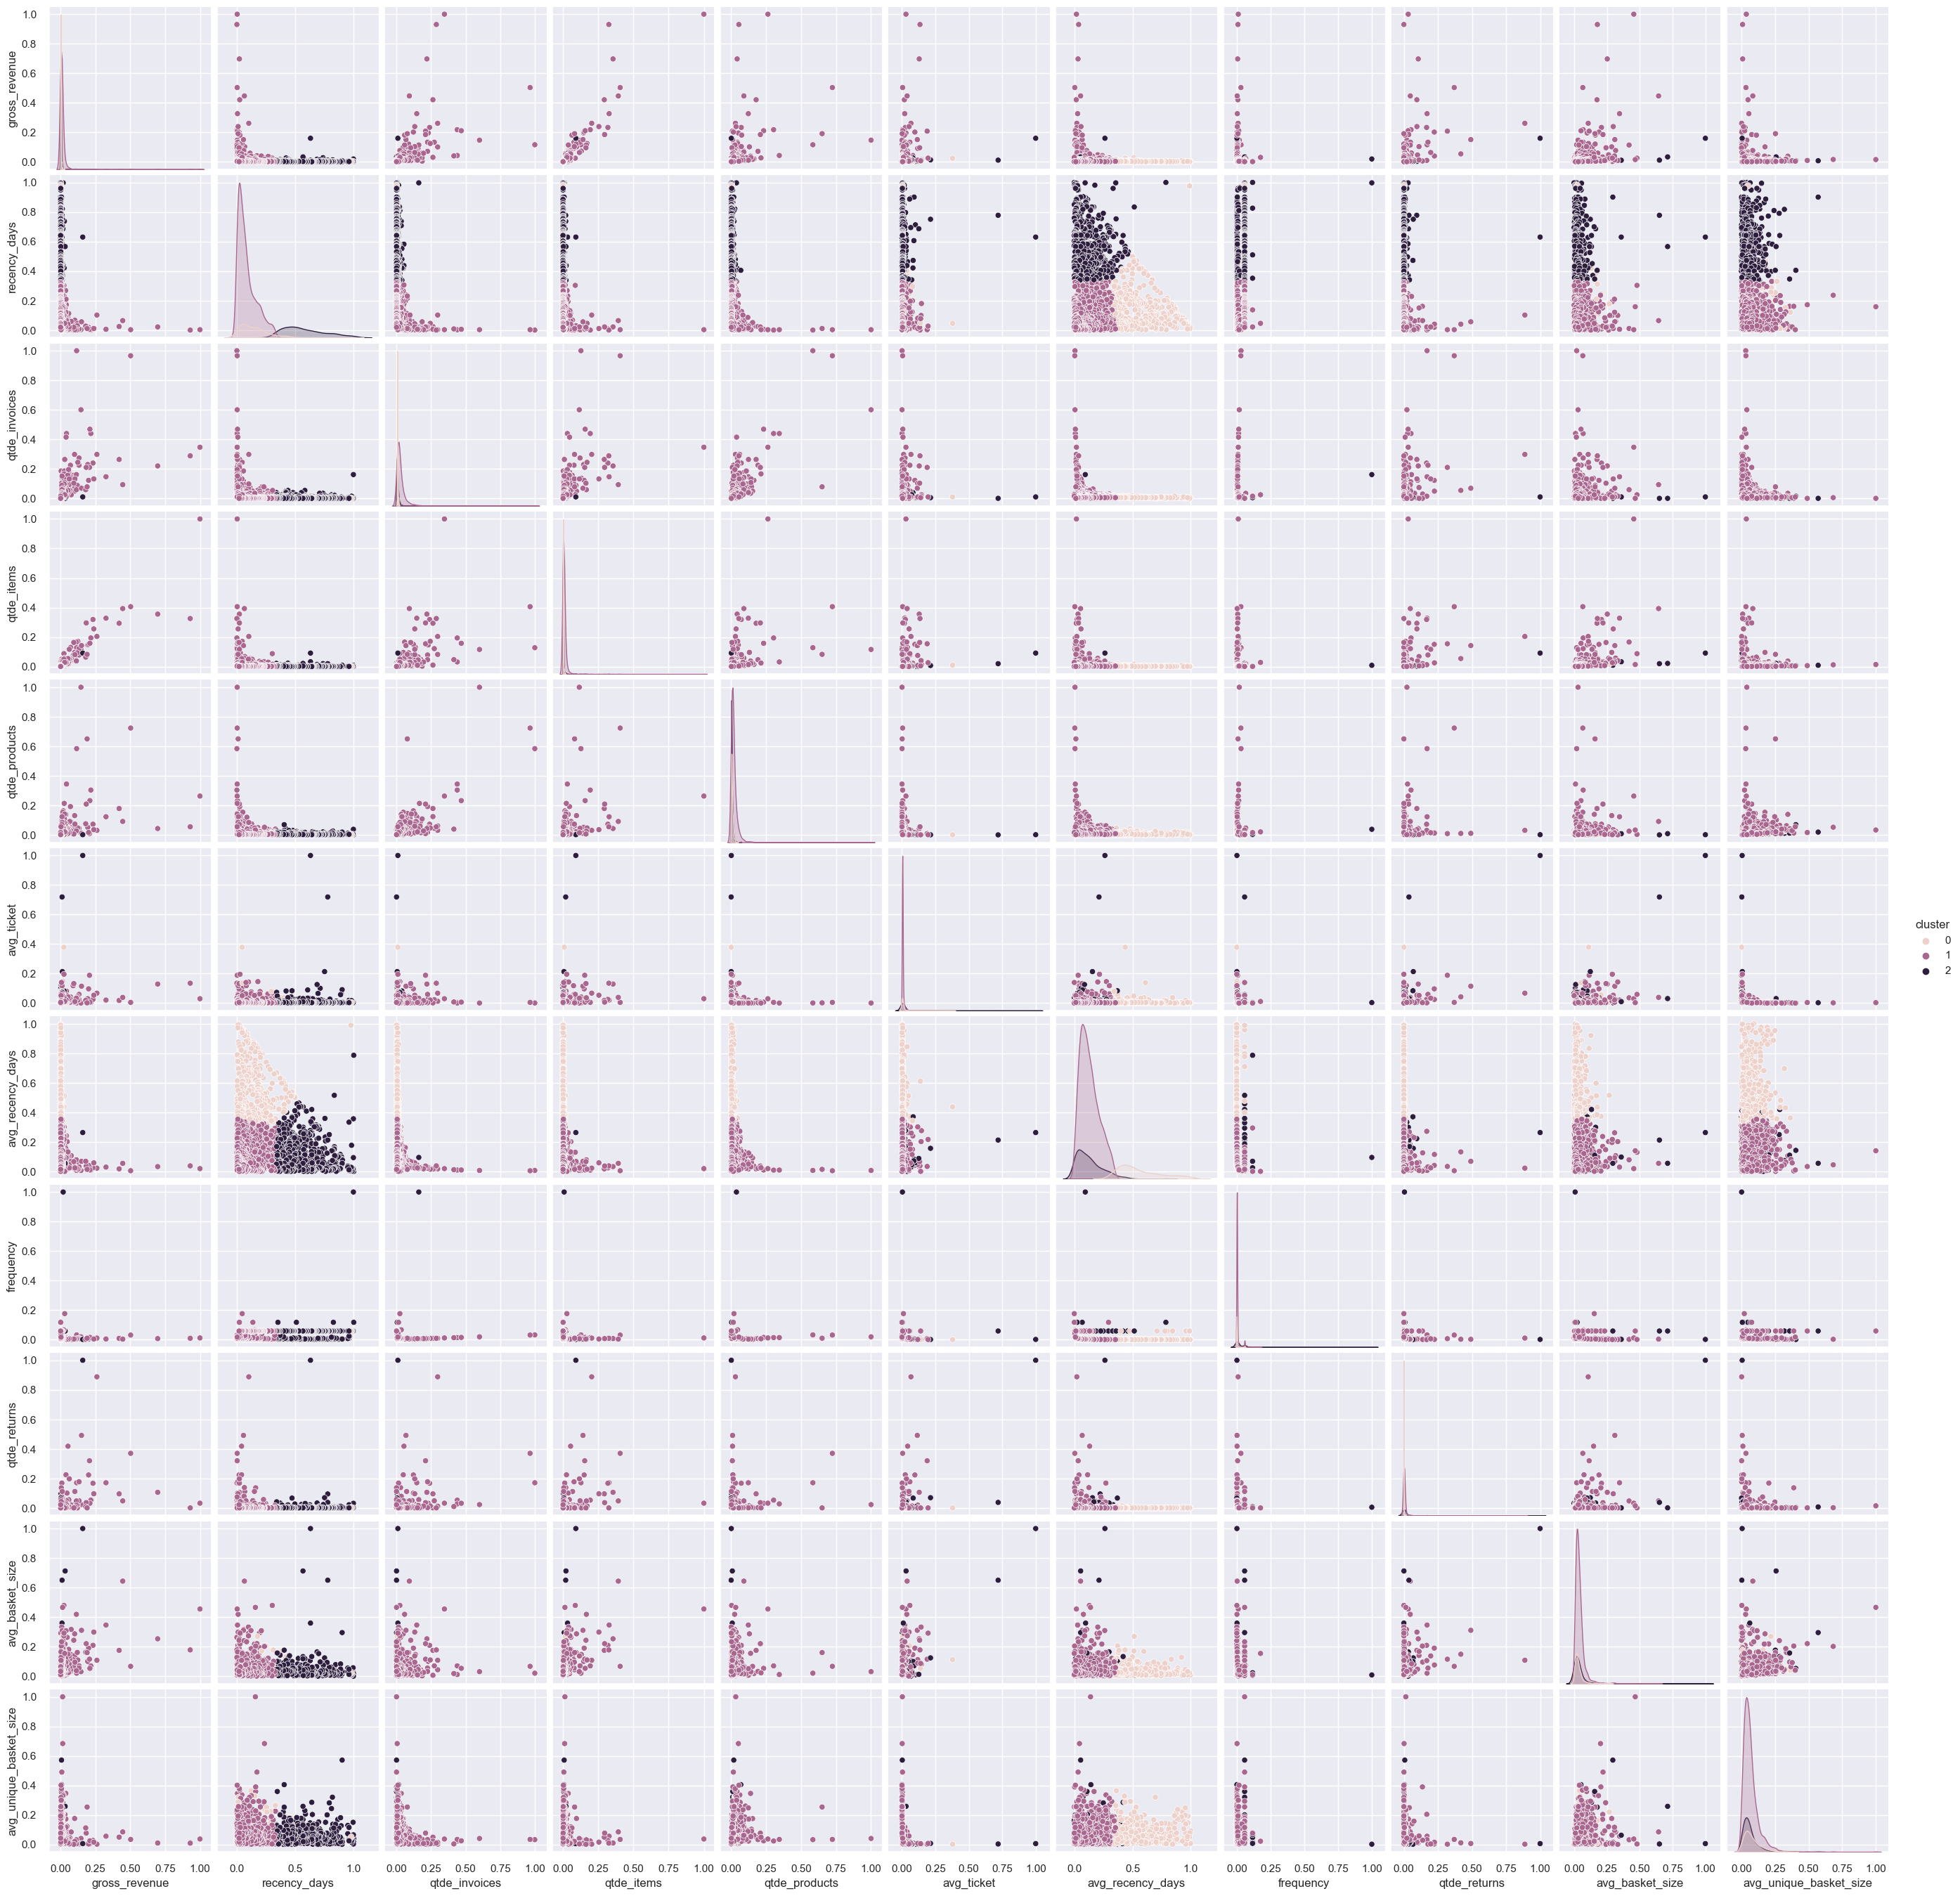

In [67]:
df_viz = df9.drop( columns='customer_id', axis=1 )
sns.pairplot( df_viz, hue='cluster')

## 9.3. UMAP 

In [103]:
df_viz = df9.drop( columns='customer_id', axis=1 )

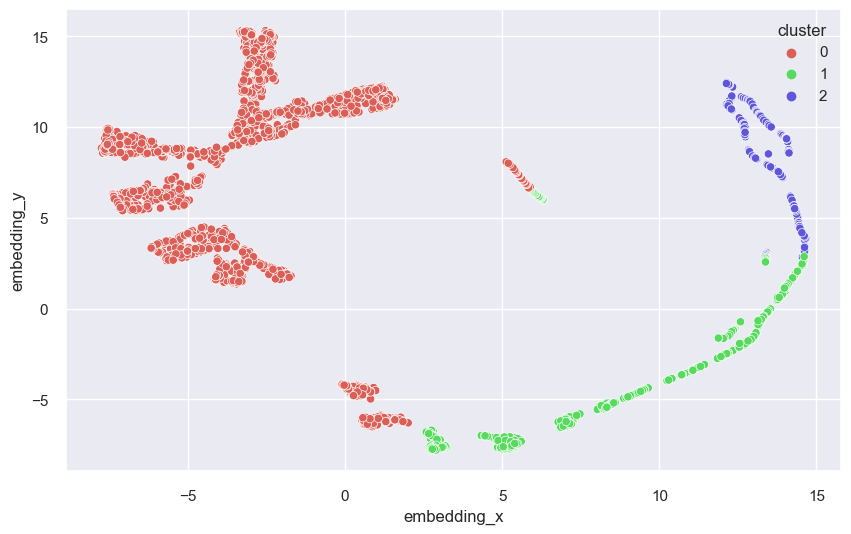

In [104]:
reducer = umap.UMAP( n_neighbors=35, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP 
plt.figure(figsize=(10, 6))
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster',
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )
plt.show()

## 9.2. Cluster Profile

In [104]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

customer_id  gross_revenue  recency_days  qtde_products  frequency  qtde_returns  cluster
0        17850        5391.21         372.0          297.0  17.000000          40.0        1
1        13047        3232.59          56.0          171.0   0.028302          35.0        5
2        12583        6705.38           2.0          232.0   0.040323          50.0        1
3        13748         948.25          95.0           28.0   0.017921           0.0        0
4        15100         876.00         333.0            3.0   0.073171          22.0        3

In [105]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_qtde_products = df92[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster

cluster  customer_id  perc_customer  gross_revenue  recency_days  qtde_products  frequency  qtde_returns
0        0          305      10.276280    2473.703672     73.006557      59.662295   0.117364     21.967213
1        1          468      15.768194    8835.897073     21.438034     424.087607   0.094571    149.271368
2        2          322      10.849057     971.000590     75.329193      37.456522   0.074586      6.571429
3        3          592      19.946092     553.689865    114.917230      14.160473   0.291256      6.538851
4        4          372      12.533693    1237.710134     61.282258      54.346774   0.043705      8.771505
5        5          145       4.885445    3164.115448     34.427586     173.841379   0.060415     23.482759
6        6          404      13.611860    1689.073490     54.809406      89.175743   0.049992     11.542079
7        7          360      12.129380    2395.119500     45.427778     127.066667   0.044792     26.866667

In [ ]:
1 Cluster Insiders
5 Cluster More Products
0 Cluster Stop Returns
7 Cluster More Frequency
6 Cluster Spend Money
4 Cluster Less Days
2 Cluster Less 1k
3 Cluster More Buy

### Cluster 01: (Candidato à Insider)
    - Numero de customers: 468 (16% dos customers)
    - Faturamento médio: 8835
    - Recência média: 21 dias
    - Média de produtos comprados: 424
    - Frequência do Produtos comprados: 0.09 produtos/dia
    - Receita em média: 8835,89 dólares

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">10.0. Análise Exploratória de Dados</p></div>         

In [106]:
df10 = df92.copy()

In [107]:
df10.head()

customer_id  gross_revenue  recency_days  qtde_products  frequency  qtde_returns  cluster
0        17850        5391.21         372.0          297.0  17.000000          40.0        1
1        13047        3232.59          56.0          171.0   0.028302          35.0        5
2        12583        6705.38           2.0          232.0   0.040323          50.0        1
3        13748         948.25          95.0           28.0   0.017921           0.0        0
4        15100         876.00         333.0            3.0   0.073171          22.0        3

## 10.1. MindMap de hipóteses

## 10.2. Hipóteses de Negócio

In [ ]:
Cluster | Variável para testar | Base de Comparação

### Hipótese Compra

1. Os clientes do cluster insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster insiders possuem um ticket médio de 10% acima do cluster More Products
3. Os clientes do cluster insiders possuem um basket size acima de 5 produtos.
4. **Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.**
5. **Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.**
6. **Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.**
7. **A mediana do faturamento pelos clientes do cluster insiders é 10% maior do que a mediana dp faturamento geral.**
8. **O percentil do preço dos produtos comprados pelos clientes insiders.**

### H1: Os clientes do cluster insiders possuem um volume (produtos) de compras acima de 10% do total de compras.
**Verdade:** Os cluster insiders possuem um volume de compra de produtos de 54%

In [109]:
# soma da qtde de produtos do insiders
df_sales_insiders = df10.loc[df10['cluster'] == 1, 'qtde_products'].sum()
df_sales_total = df10.loc[:, 'qtde_products'].sum()

# soma da qtde de produtos total
print( '% Sales Insiders: {:.2f}%'.format( 100*df_sales_insiders/df_sales_total ) )

% Sales Insiders: 54.48%


### H2: Os clientes do cluster insiders possuem um volume (faturamento) de compras acima de 10% do total de compras.
**Verdadeiro:** O cluster insiders possuem um volume de GMV de 52%

In [110]:
# soma da qtde de produtos do insiders
df_gmv_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# soma da qtde de produtos total
print( '% GMV Insiders: {:.2f}%'.format( 100*df_gmv_insiders/df_gmv_total ) )

% GMV Insiders: 51.73%


### H3: Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.
**Falso** O cluster insiders tem média de devoluções acima da média geral

In [111]:
# média de devolução do cluster insider
df_avg_return_insiders = df10.loc[df10['cluster'] == 1, 'qtde_returns'].mean()

# média de devolução do total
df_avg_return_all = df10['qtde_returns'].mean()

print( 'Avg Return Insiders: {} vs Avg Return All: {}'.format( np.round( df_avg_return_insiders, 0 ), np.round( df_avg_return_all, 0 ) ) )

Avg Return Insiders: 149.0 vs Avg Return All: 35.0


### H4: A mediana do faturamento pelos clientes do cluster insiders é 10% maior do que a mediana dp faturamento geral.
**Verdadeiro** A média do faturamento é 276% acima da média.

In [112]:
# mediana de gmv do insiders
df_median_gmv_insiders = df10.loc[df10['cluster'] == 1, 'gross_revenue'].median()

# mediana de gmv do total
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

gmv_diff = ( df_median_gmv_insiders - df_median_gmv_total ) / df_median_gmv_total
print( 'Median Diff: {:.2f}%'.format( 100*gmv_diff ) )

Median Diff: 276.22%


### H5: O gmv dos clientes insiders esta concentrados no 3º quartil.
**Falso** O faturamento do cluster insiders está concentrado no quartil 1

<AxesSubplot: xlabel='gross_revenue'>

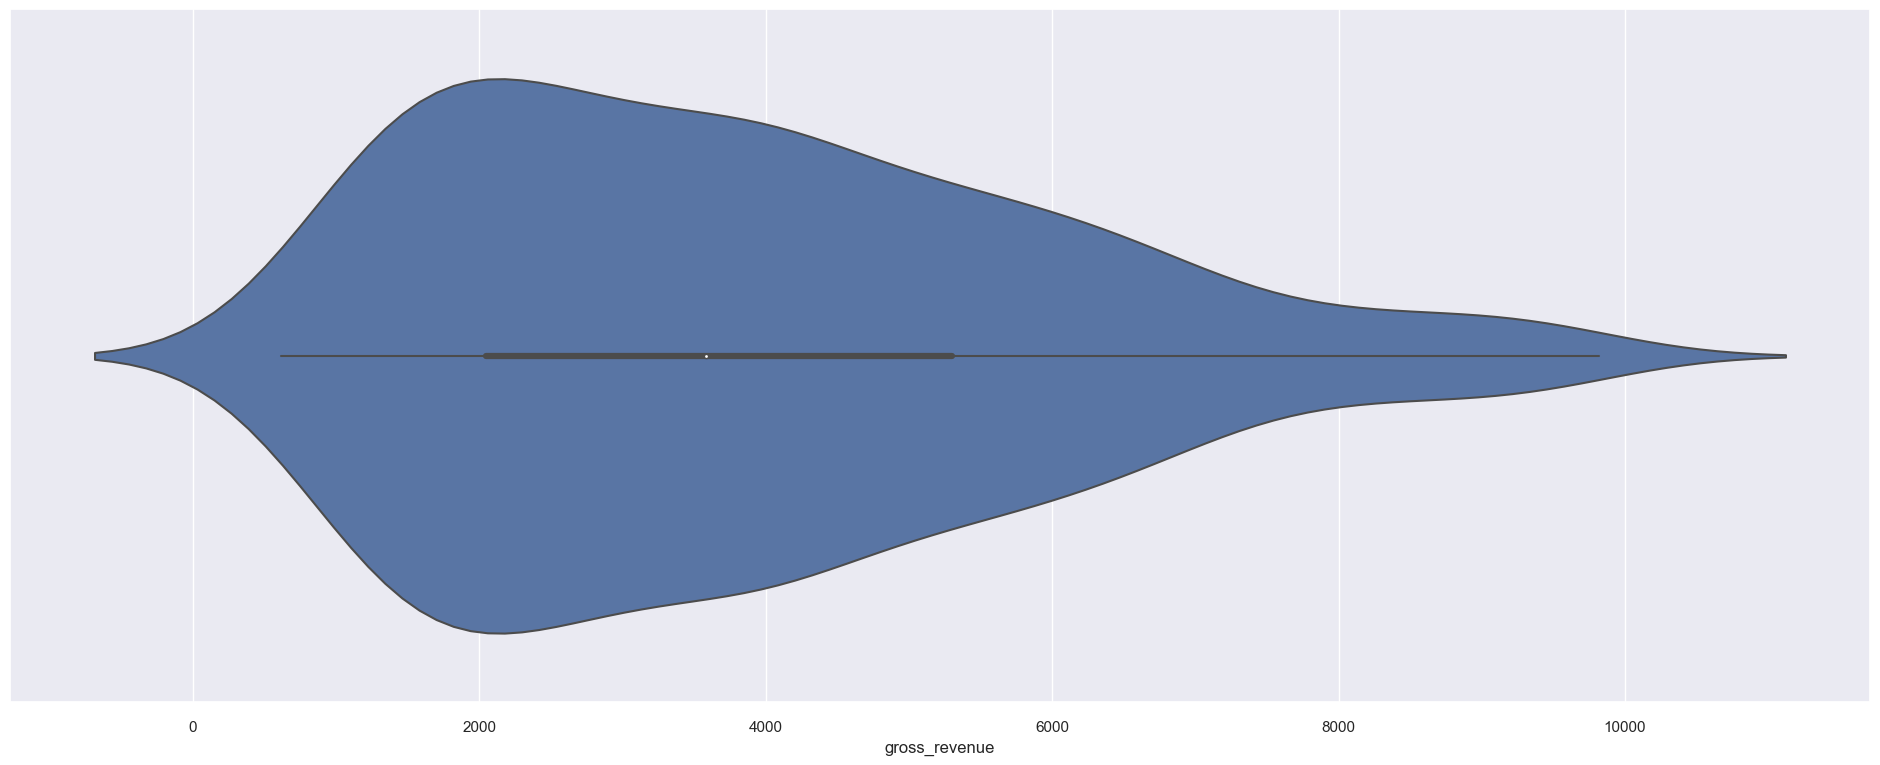

In [113]:
df_aux = df10.loc[(df10['cluster'] == 1) & (df10['gross_revenue'] < 10000 ), 'gross_revenue'];
sns.violinplot( x=df_aux ) 

### Hipótese Cliente

1. 60% dos clientes do cluster insiders possuem o estado civil de solteiro.
2. 10% dos clientes do cluster insiders estão na faixa de 24-35 anos.
3. 40% das localidades de entrega do cluster insiders estão dentro de um raio de 50km.
4. 5% dos clientes do cluster insiders recebem mais de 100 mil dólares anualmente.
5. 90% dos clientes do cluster insiders tem ensino superior completo.

### Hipótese Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster insiders é 10% maior do que a mediana de todos os preços dos produtos.
3. O percentil do preço dos produtos comprados pelos clientes insiders.
4. O peso médio dos produtos comprados pelos clientes do cluster insiders é maior do que o peso médio dos outros clusters.
5. A idade média dos produtos comprados pelos clientes do cluster insiders é menor do que 15 dias.

### Perguntas de Negócio

### 1. Quem são as pessoas elegíveis para participar do programa de Insiders?

In [115]:
df10.loc[df10['cluster'] == 1, 'customer_id'].head()

0     17850
2     12583
6     14688
8     15311
12    16029
Name: customer_id, dtype: int64

### 2. Quantos clientes farão parte do grupo?

In [116]:
df10.loc[df10['cluster'] == 1, 'customer_id'].size

468

### 3. Quais as principais características desses clientes?

#### Cluster 01: (Candidato à Insider)
    - Numero de customers: 468 (16% dos customers)
    - Faturamento médio: 8835
    - Recência média: 21 dias
    - Média de produtos comprados: 424
    - Frequência do Produtos comprados: 0.09 produtos/dia
    - Receita em média: 8835,89 dólares

### 4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?

In [118]:
df_insiders_gmv = df10.loc[df10['cluster'] == 1, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:, 'gross_revenue'].sum()

print( '% GMV from Insiders: {}'.format( df_insiders_gmv / df_all_gmv ) )

% GMV from Insiders: 0.5172892609036236


### 5. Qual a expectativa de faturamento desse grupo para os próximos meses?

### 6. Quais as condições para uma pessoa ser elegível ao Insiders?

### 7. Quais as condições para uma pessoa ser removida do Insiders?

8. Qual a garantia que o programa Insiders é melhor que o restante da base?

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## 10.3. Priorização das Hipótese

## 10.4 Validação das Hipóteses

## 10.5. Quadro de Respostas

# <div style="color:red;display:fill;border-radius:15px;background-color:#5d6d7e;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">11.0. Deploy to Production</p></div>         